In [265]:
import pickle

from math import floor
from math import copysign
from tqdm import tqdm

from time import time
from time import sleep

from collections import defaultdict

from dataclasses import dataclass

from statistics import mean

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from compas.datastructures import network_transformed

from compas.geometry import Line
from compas.geometry import Polyline
from compas.geometry import Translation
from compas.geometry import Transformation
from compas.geometry import Frame
from compas.geometry import offset_polyline
from compas.geometry import transform_vectors

from compas_cem.diagrams import TopologyDiagram

from compas_cem.elements import DeviationEdge
from compas_cem.elements import TrailEdge

from compas_cem.loads import NodeLoad

from compas_cem.supports import NodeSupport

from compas_cem.equilibrium import static_equilibrium

from compas_cem.optimization import LineConstraint
from compas_cem.optimization import TrailEdgeForceConstraint
from compas_cem.optimization import DeviationEdgeParameter
from compas_cem.optimization import TrailEdgeParameter
from compas_cem.optimization import Optimizer

from compas_cem.plotters import Plotter

In [79]:
def bridge(chords, num_hangers, height, width, edge_forces, node_load):
    """
    Create the topology diagram of a curved bridge subject to torsioning loads.
    """
    # test number of hangers is even
    assert num_hangers % 2 == 0
    
    num_segments = num_hangers - 1
    
    # create chords 
    chord_bottom, chord_top, chord_deck = chords

    # instantiate a topology diagram
    topology = TopologyDiagram()
    
    # unpack forces
    force_chord_bottom = forces["force_chord_bottom"]
    force_chord_top = forces["force_chord_top"]
    force_hanger_vertical = forces["force_hanger_vertical"]
    force_hanger_deck = forces["force_hanger_deck"]
    force_hanger_tie = forces["force_hanger_tie"]

    # add chord edges
    for chord, force in zip((chord_bottom, chord_top), (force_chord_bottom, force_chord_top)):
        lines = chord.lines

        index_middle = floor(num_segments / 2.)
        line_middle = lines.pop(index_middle)  # edge in the middle is a deviation edge
        edge = DeviationEdge.from_line(line_middle, force=force)
        topology.add_edge(edge)

        for line in lines:
            state = copysign(1., force)
            edge = TrailEdge.from_line(line, length=line.length * state)
            topology.add_edge(edge)

    # add hanger edges
    hangers = [((chord_bottom, chord_top), force_hanger_vertical),
               ((chord_top, chord_deck), force_hanger_tie),
               ((chord_deck, chord_bottom), force_hanger_deck)]

    for chords, force in hangers:
        for line in zip(*chords):
            edge = DeviationEdge.from_line(line, force=force)
            topology.add_edge(edge)

    # add supports at the start and end of the top and bottom chords
    for chord in (chord_bottom, chord_top):
        points = chord.points
        for point in (points[0], points[-1]):
            support = NodeSupport.from_point(point)
            topology.add_support(support)

    # add loads
    for point in chord_deck.points:
        load = NodeLoad.from_point_and_vector(point, vector=node_load)
        topology.add_load(load)

    # build trails
    topology.auxiliary_trail_vector = [0., 0., 1.]
    topology.build_trails(auxiliary_trails=True)

    return topology


def reoriented_diagram(diagram, transf):
    # Re-orient node positions
    diagram_transformed = network_transformed(diagram, transf)

    # Squash node positions to plane
    z = frame_to.point.z
    for node in diagram_transformed.nodes():
        diagram_transformed.node_attribute(node, "z", z)

    # Re-orient and squash loads
    for node in diagram_transformed.nodes():
        # loads
        load = diagram_transformed.node_load(node)
        loadt = transform_vectors([load], transf).pop()
        diagram_transformed.node_attributes(node, ("qx", "qy", "qz"), loadt)

        # reaction force
        reaction = diagram_transformed.reaction_force(node)
        reactiont = transform_vectors([reaction], transf).pop()
        diagram_transformed.node_attributes(node, ("rx", "ry", "rz"), reactiont)
        
    return diagram_transformed


def reoriented_lines(lines, transf):
    return [line.transformed(transf) for line in lines]


def plot_diagrams(topology, form, form_opt, lines, frame_from, frame_to, figsize=(9.0, 9.0), nodesize=3, loadscale=1.0, reactionscale=1.0):
    plottable_diagrams = {"T": topology, "F": form, "CF": form_opt}
    transf = Transformation.from_frame_to_frame(frame_from, frame_to)
    lines = reoriented_lines(lines, transf)
    
    for name, diagram in plottable_diagrams.items():
        plotter = Plotter(figsize=figsize)
        diagram = reoriented_diagram(diagram, transf)
        plotter.add(diagram, nodesize=nodesize, loadscale=loadscale, reactionscale=reactionscale)
        
        if name in ("F", "CF"):
            
            for line in lines:
                plotter.add(line)
        
        plotter.zoom_extents(padding=-0.3)
        plotter.show()
    

class Logger:
    opt_attrs = ["time", "evals", "penalty", "grad_norm"]
    
    def __init__(self):
        self.data = defaultdict(list)
        self.opt_data = {attr: defaultdict(dict) for attr in self.opt_attrs} 
        
    def log_numhangers(self, num_hangers):
        self.data["num_hangers"].append(num_hangers)
        
    def log_topology(self, topology):
        self.data["num_nodes"].append(topology.number_of_nodes())
        self.data["num_edges"].append(topology.number_of_edges())
        
    def log_optimizer(self, optimizer):
        self.data["num_parameters"].append(optimizer.number_of_parameters())
        self.data["num_constraints"].append(optimizer.number_of_constraints())
    
    def log_result(self, result):
        key1 = result.gradient_mode
        key2 = result.step_size_exp
        
        for attr in self.opt_attrs:
            slot = self.opt_data[attr][key1]
            value = getattr(result, attr)
            
            if not key2 in slot:
                slot[key2] = []

            slot[key2].append(value)
    
    def flush_results(self):
        self.data["results"].append(self.opt_data)
        self.opt_data = {attr: defaultdict(dict) for attr in self.opt_attrs} 
      

@dataclass
class OptimizationResult:
    evals : float
    time: float
    penalty: float
    grad_norm: float
    gradient_mode: str
    step_size_exp: float

In [85]:
nums_hangers = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
curve_path = "bridge_curve.json"

# geometry parameters
height = 1.
width = 1.

# topology diagram parameters
forces = {}
forces["force_chord_bottom"] = -5.
forces["force_chord_top"] = 5.
forces["force_hanger_vertical"] = -0.1
forces["force_hanger_deck"] = -1.5
forces["force_hanger_tie"] = 1.5

# load, uniformly distributed line load along deck 
load_line = -1.

# optimization parameters
# gradient strategy = {grad method: step_size_exponents}
gradient_strategy = {"AD": [None], "FD": [-3, -6, -9, -12]}
# gradient_strategy = {"AD": [None]}

opt_algorithm = "SLSQP"
iters = 100
eps = 1e-6

bound_force = 10.
bound_length = 0.5
target_line_height = 5.

# number of experiments to average results on
num_experiments = 10

# visualization
plot = True

figsize = (9, 9)
frame_to = Frame(point=[0.0, 0.0, 0.0],
                 xaxis=[1.0, 0.0, 0.0],
                 yaxis=[0.0, 1.0, 0.0])

frame_from = Frame(point=[9.455336, -16.765659, 17.172092],
                   xaxis=[0.66914, 0.743136,0],
                   yaxis=[-0.438693,0.395011,0.807165])

  0%|          | 0/10 [00:00<?, ?it/s]

***Solving for bridge with 4 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 18, # Constraints 8
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:00<00:05,  1.63it/s]

Optimization ended correctly!
Optimization total runtime: 0.587034 seconds
Number of evaluations incurred: 25
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.00029
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

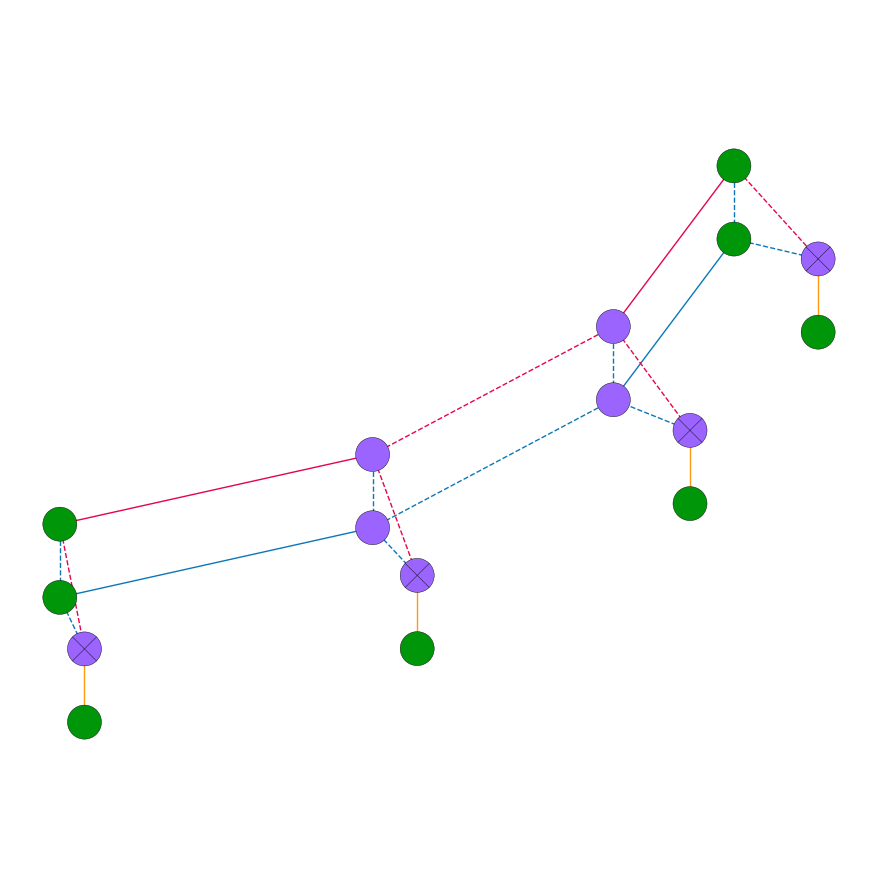

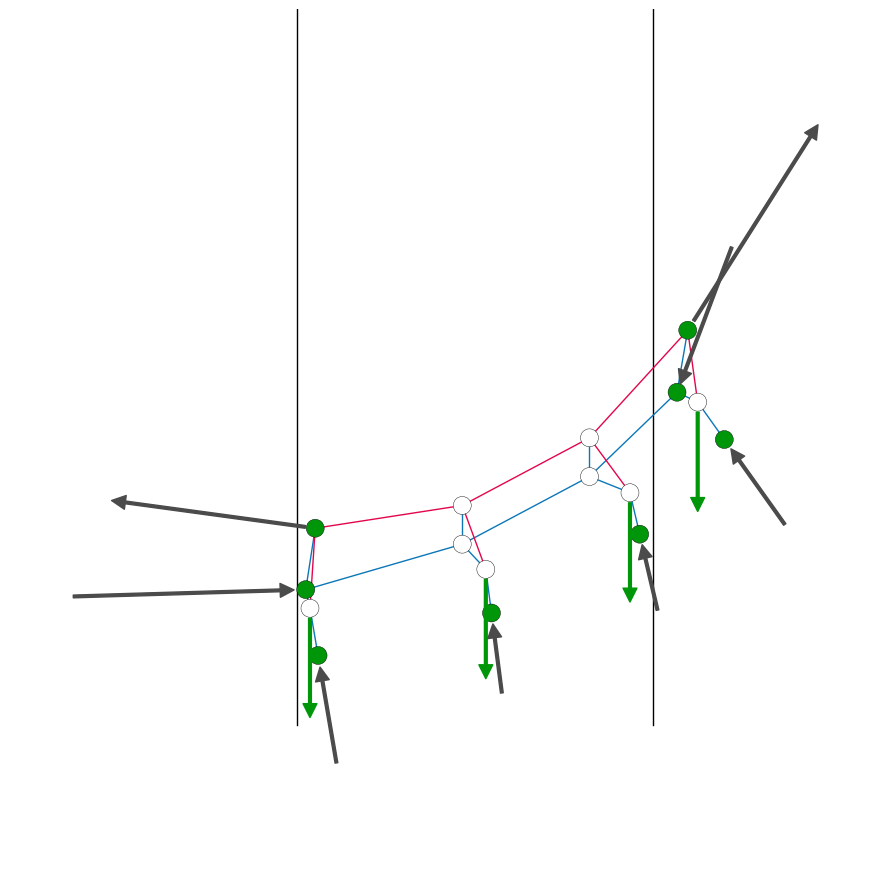

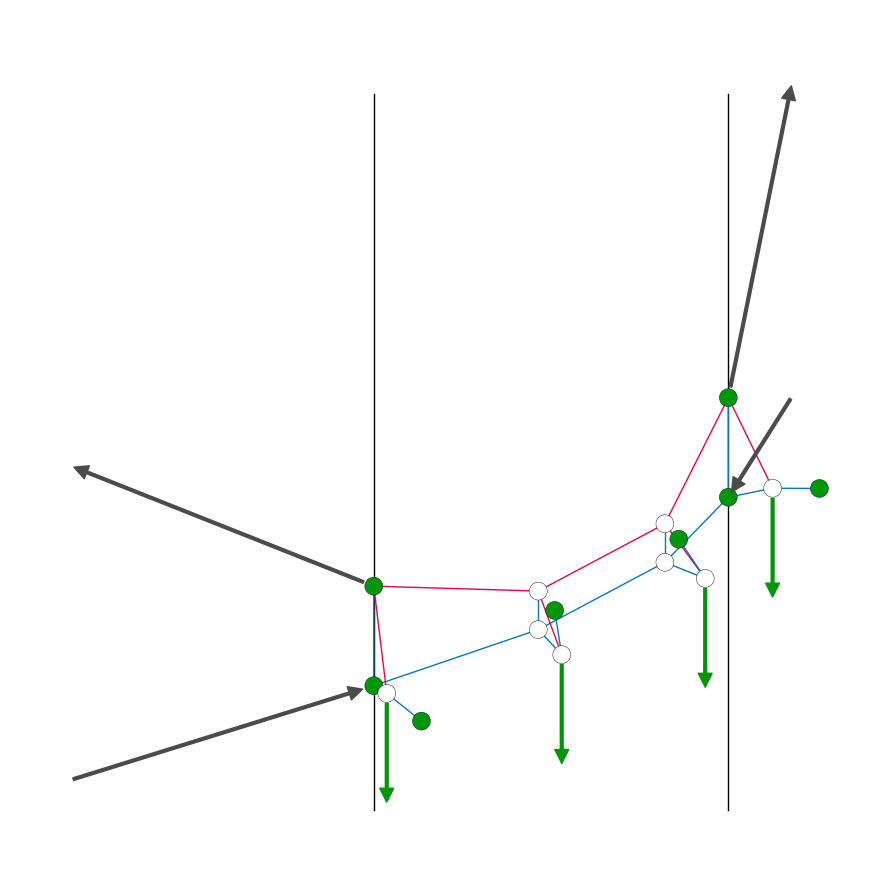

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 18, # Constraints 8


 10%|█         | 1/10 [00:02<00:19,  2.12s/it]

Optimization ended correctly!
Optimization total runtime: 2.065497 seconds
Number of evaluations incurred: 100
Final value of the objective function: 4e-06
Norm of the gradient of the objective function: 0.002719
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 18, # Constraints 8


 10%|█         | 1/10 [00:01<00:10,  1.22s/it]

Optimization ended correctly!
Optimization total runtime: 1.155843 seconds
Number of evaluations incurred: 25
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000508
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 18, # Constraints 8


 10%|█         | 1/10 [00:01<00:12,  1.37s/it]

Optimization ended correctly!
Optimization total runtime: 1.308706 seconds
Number of evaluations incurred: 30
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000804
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 18, # Constraints 8


 10%|█         | 1/10 [00:01<00:11,  1.26s/it]

Optimization ended correctly!
Optimization total runtime: 1.206743 seconds
Number of evaluations incurred: 28
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.001132
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 6 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 24, # Constraints 10
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:01<00:13,  1.53s/it]

Optimization ended correctly!
Optimization total runtime: 1.477727 seconds
Number of evaluations incurred: 28
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001605
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

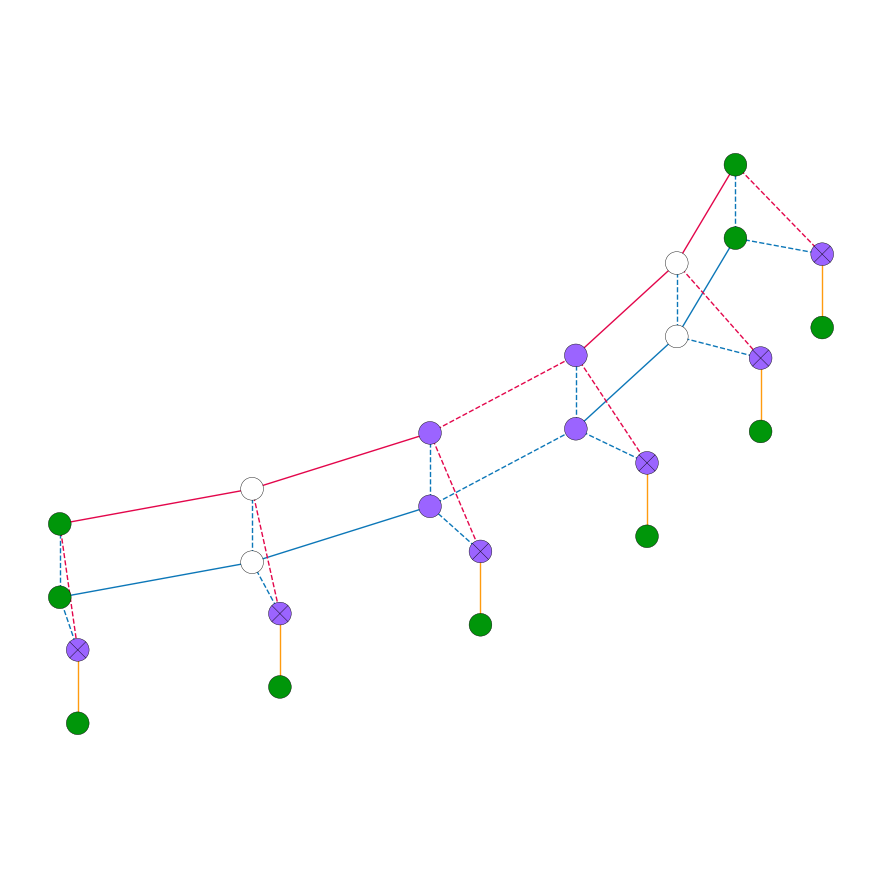

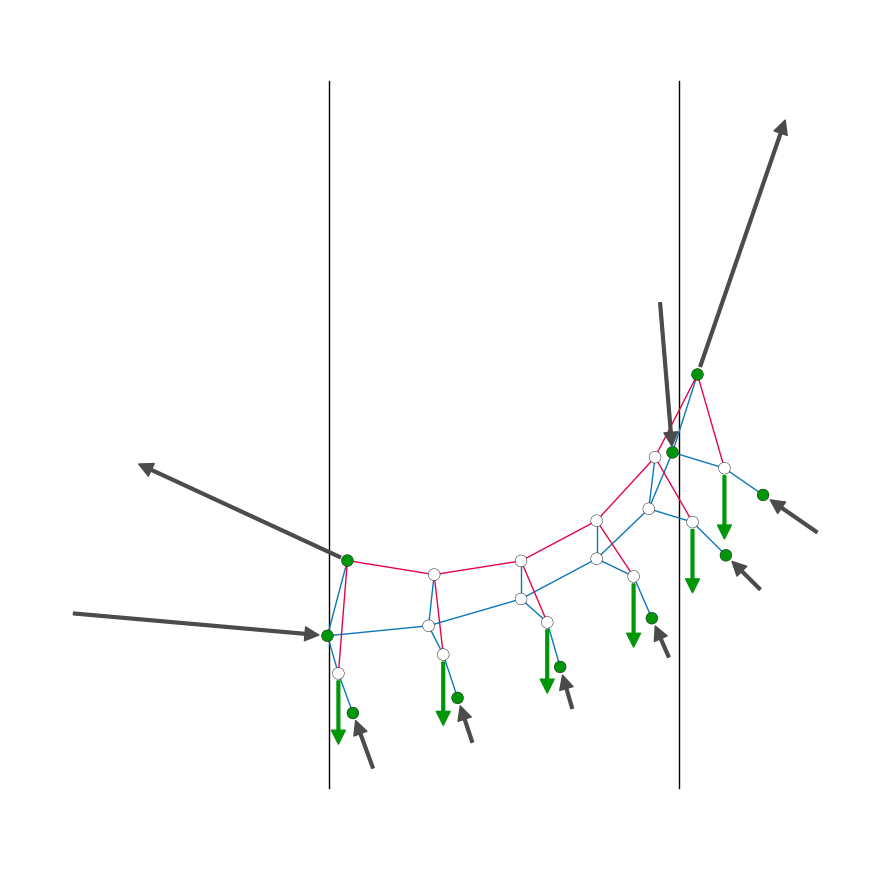

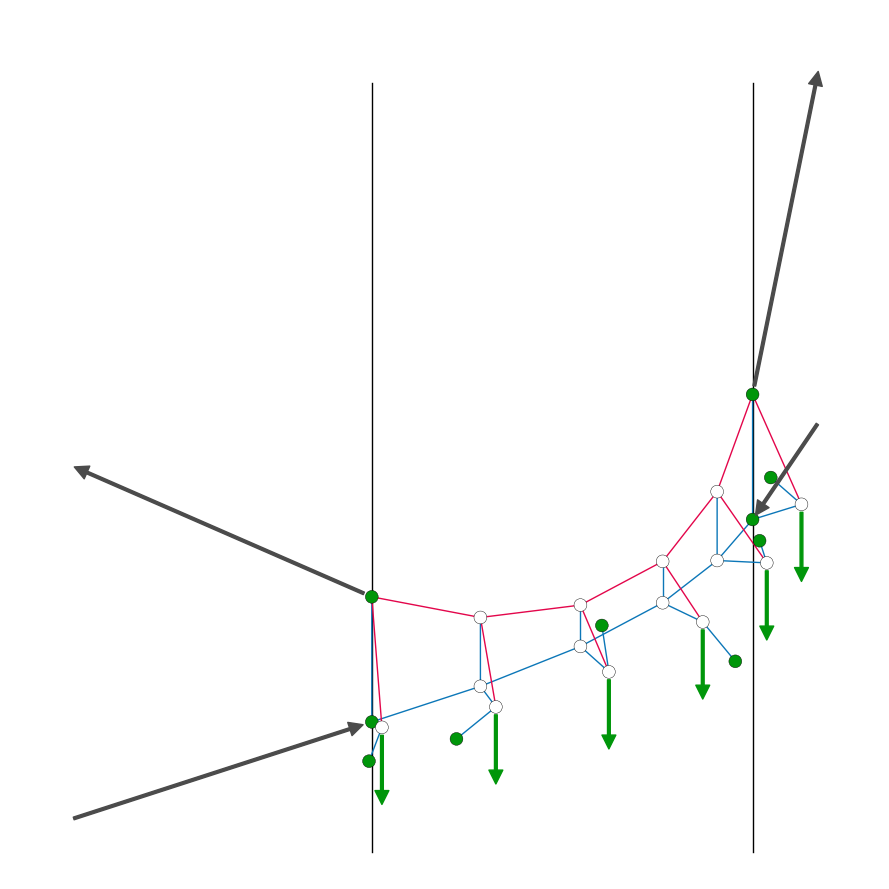

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 24, # Constraints 10


 10%|█         | 1/10 [00:05<00:52,  5.86s/it]

Optimization ended correctly!
Optimization total runtime: 5.720299 seconds
Number of evaluations incurred: 100
Final value of the objective function: 9.7e-05
Norm of the gradient of the objective function: 0.010385
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 24, # Constraints 10


 10%|█         | 1/10 [00:03<00:33,  3.69s/it]

Optimization ended correctly!
Optimization total runtime: 3.55239 seconds
Number of evaluations incurred: 30
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.001384
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 24, # Constraints 10


 10%|█         | 1/10 [00:03<00:31,  3.48s/it]

Optimization ended correctly!
Optimization total runtime: 3.355396 seconds
Number of evaluations incurred: 30
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000836
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 24, # Constraints 10


 10%|█         | 1/10 [00:03<00:31,  3.47s/it]

Optimization ended correctly!
Optimization total runtime: 3.284488 seconds
Number of evaluations incurred: 29
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000591
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 8 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 30, # Constraints 12
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:03<00:33,  3.68s/it]

Optimization ended correctly!
Optimization total runtime: 3.603853 seconds
Number of evaluations incurred: 43
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000913
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [00:32<00:00,  3.21s/it]

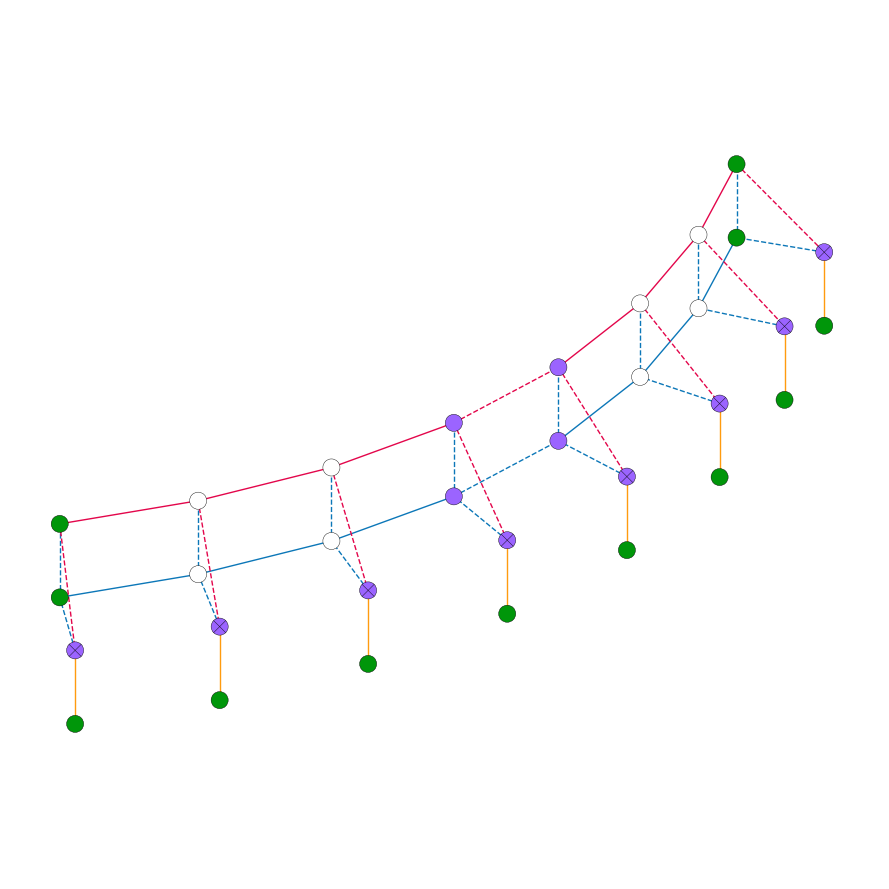

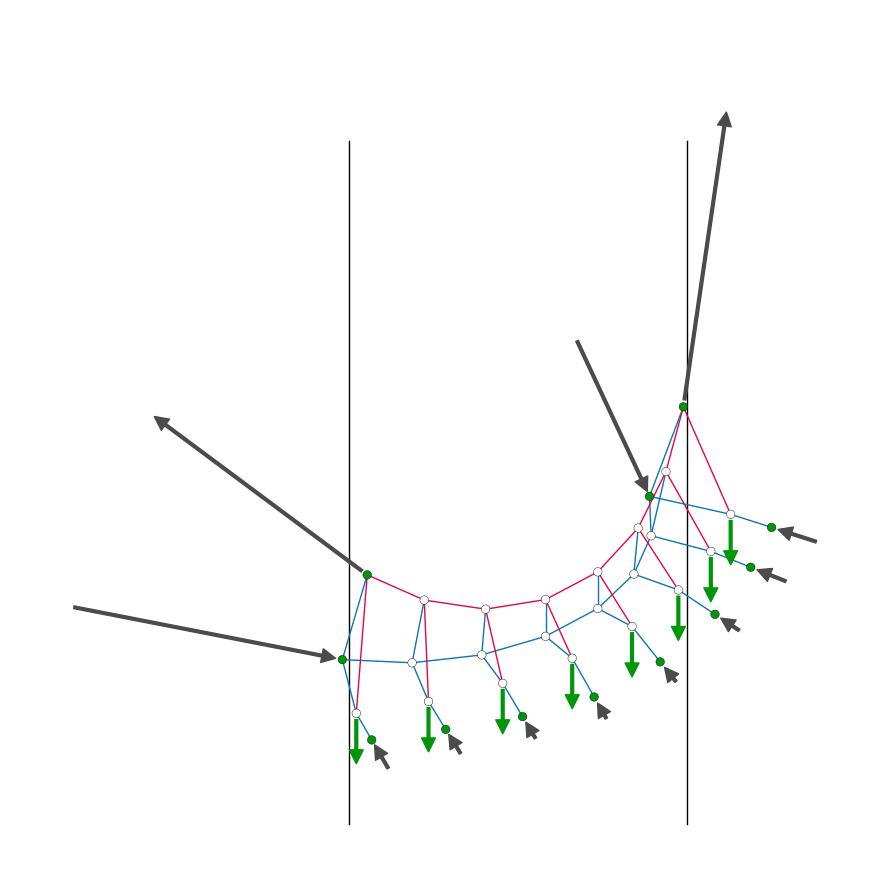

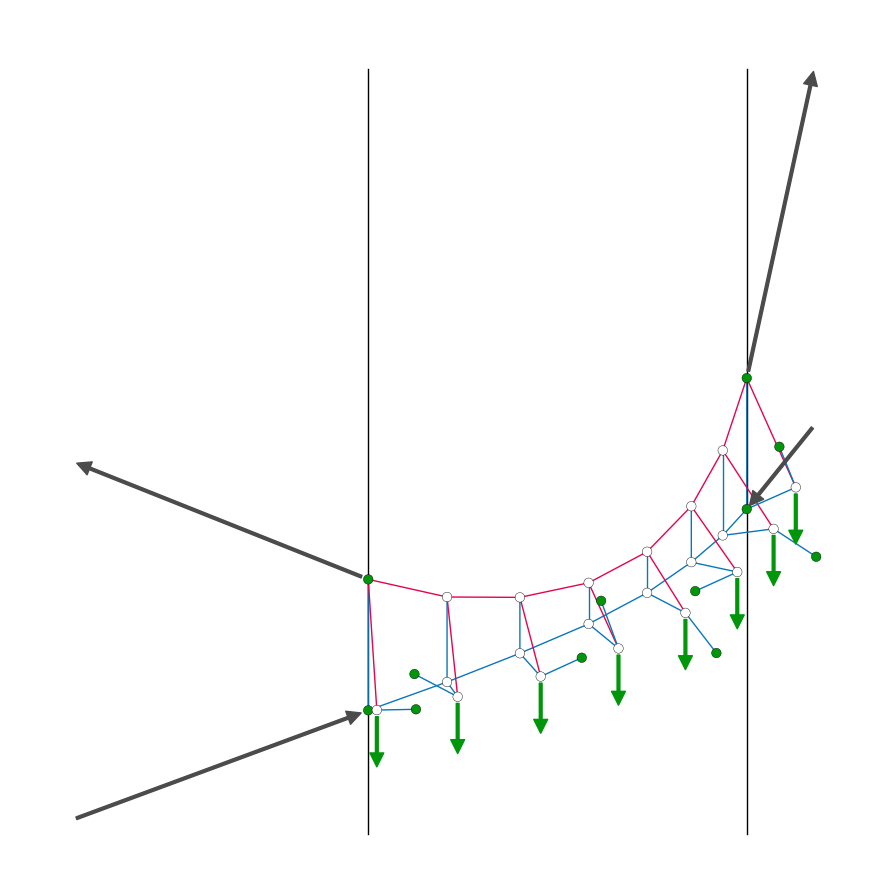

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 30, # Constraints 12


 10%|█         | 1/10 [00:08<01:12,  8.11s/it]

Optimization ended correctly!
Optimization total runtime: 7.919429 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000125
Norm of the gradient of the objective function: 0.005033
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 30, # Constraints 12
Optimization ended correctly!


 10%|█         | 1/10 [00:07<01:10,  7.83s/it]

Optimization total runtime: 7.590033 seconds
Number of evaluations incurred: 44
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.00159
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 30, # Constraints 12
Optimization ended correctly!
Optimization total runtime: 7.746008 seconds
Number of evaluations incurred: 43
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000604
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 30, # Constraints 12
Optimization ended correctly!
Optimization total runtime: 7.566782 seconds
Number of evaluations incurred: 43
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001041
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 10 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 36, # Constraints 14
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:04<00:40,  4.48s/it]

Optimization ended correctly!
Optimization total runtime: 4.398494 seconds
Number of evaluations incurred: 49
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000209
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [00:44<00:00,  4.46s/it]

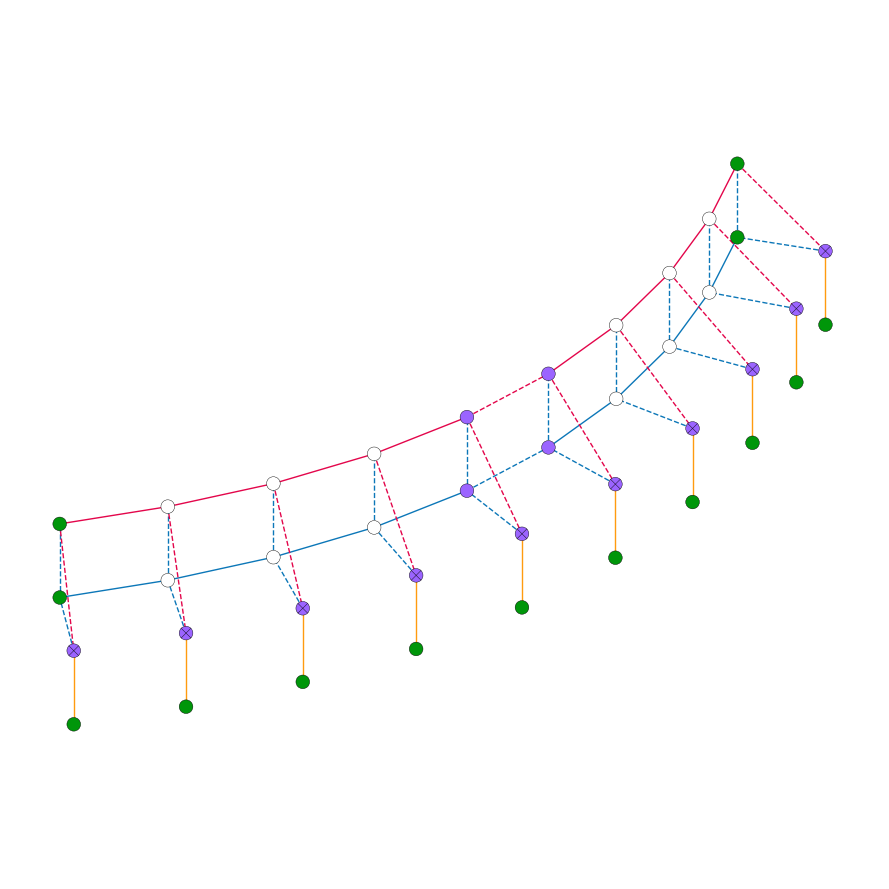

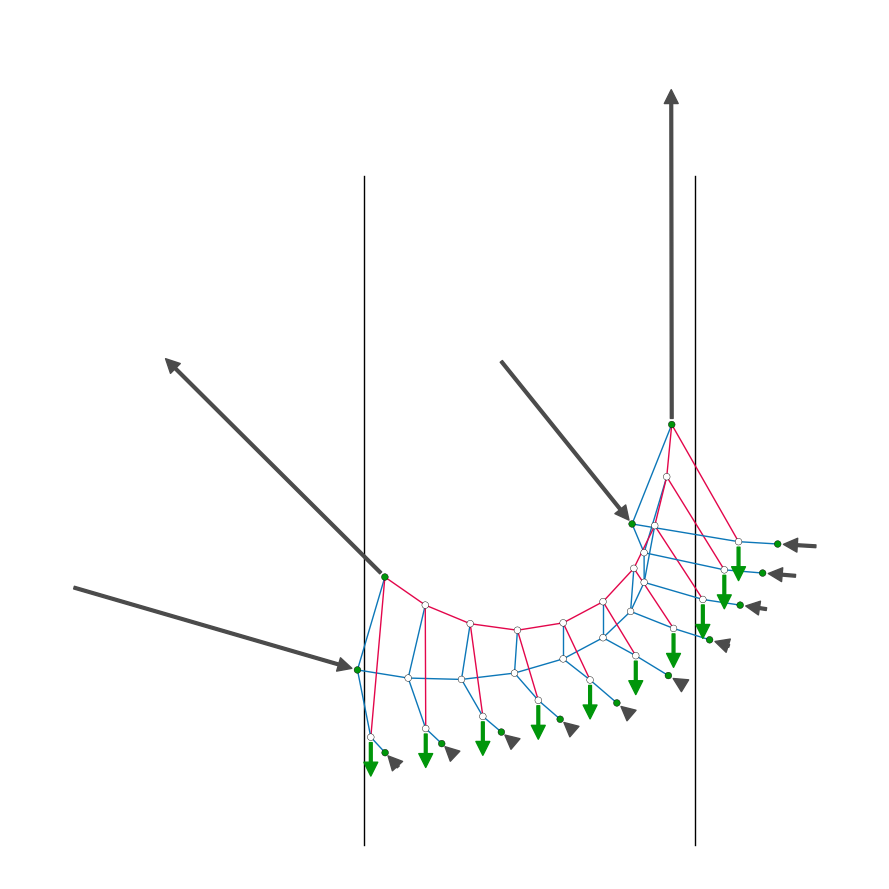

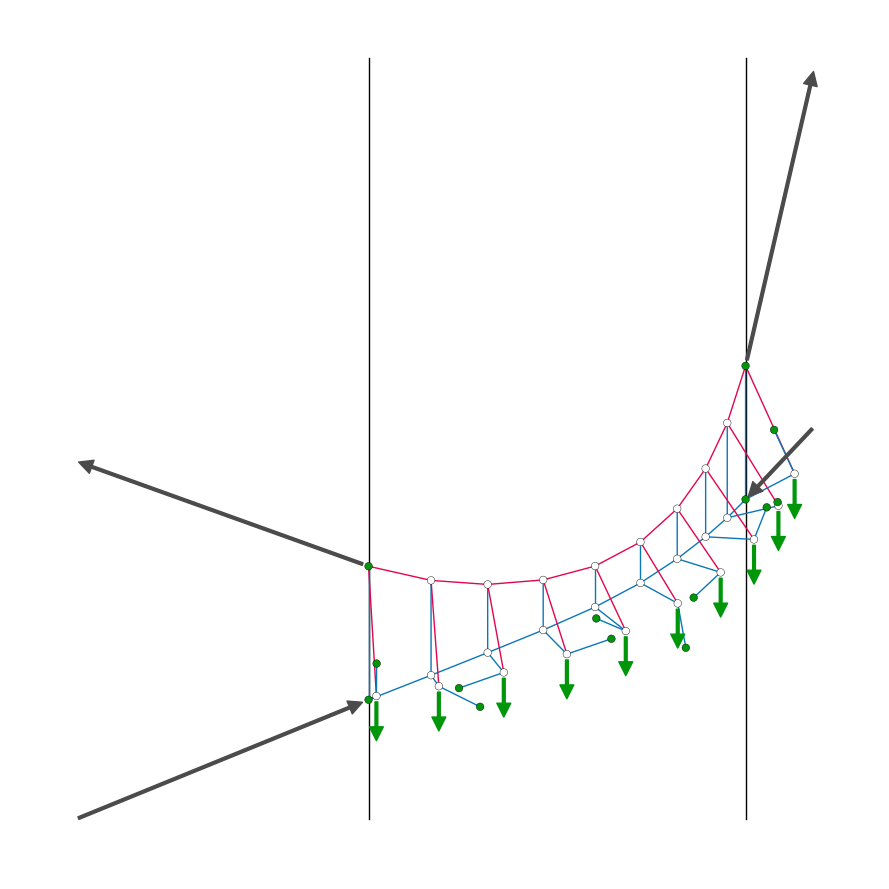

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 36, # Constraints 14
Optimization ended correctly!


 10%|█         | 1/10 [00:12<01:56, 12.95s/it]

Optimization total runtime: 12.631497 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000109
Norm of the gradient of the objective function: 0.005146
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 36, # Constraints 14
Optimization ended correctly!


 10%|█         | 1/10 [00:12<01:55, 12.84s/it]

Optimization total runtime: 12.533812 seconds
Number of evaluations incurred: 49
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000206
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 36, # Constraints 14
Optimization ended correctly!


 10%|█         | 1/10 [00:14<02:11, 14.65s/it]

Optimization total runtime: 14.335252 seconds
Number of evaluations incurred: 54
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000135
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 36, # Constraints 14
Optimization ended correctly!


 10%|█         | 1/10 [00:14<02:09, 14.34s/it]

Optimization total runtime: 14.017318 seconds
Number of evaluations incurred: 54
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000449
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 12 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 42, # Constraints 16
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:07<01:03,  7.06s/it]

Optimization ended correctly!
Optimization total runtime: 6.964051 seconds
Number of evaluations incurred: 65
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001169
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [01:14<00:00,  7.41s/it]

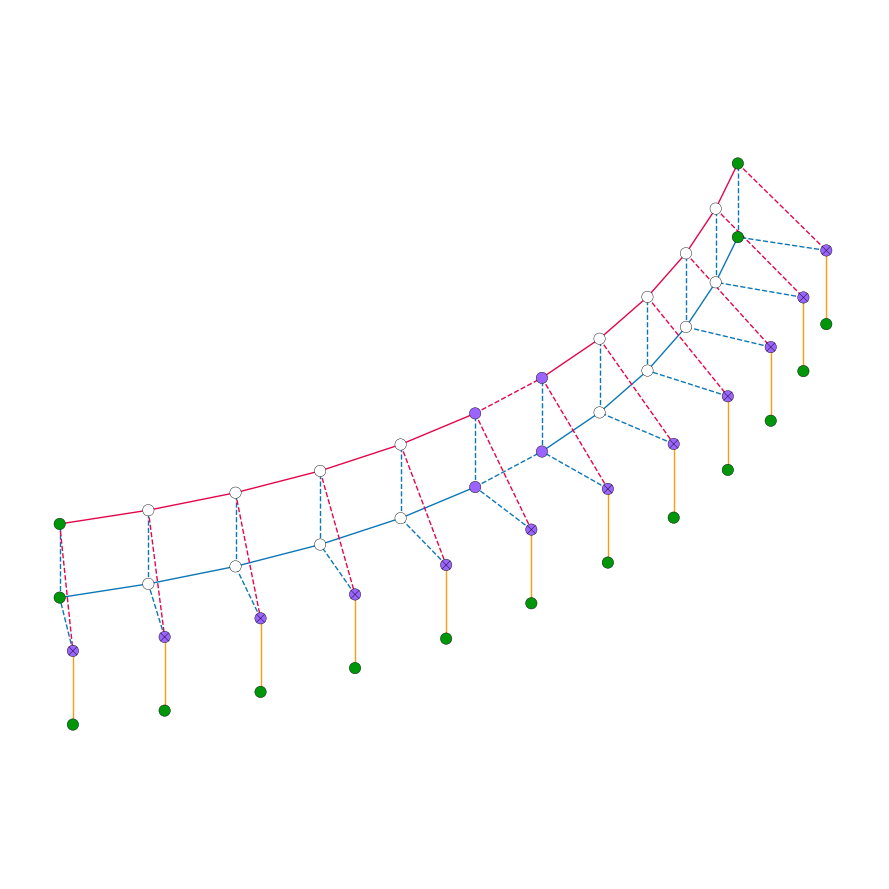

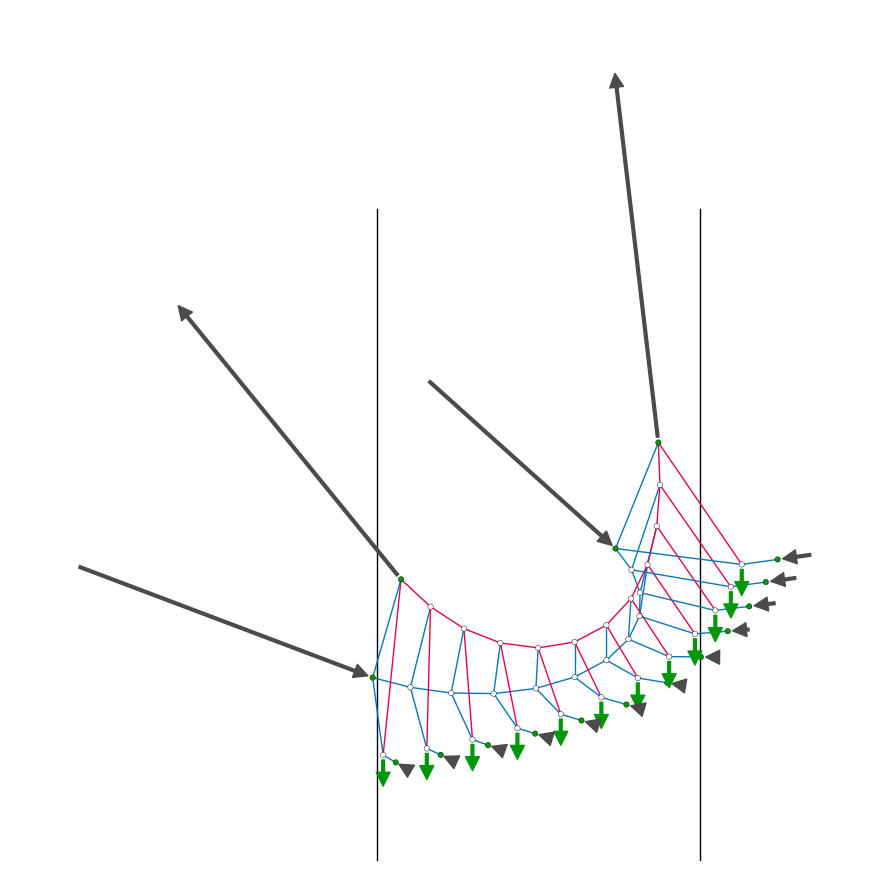

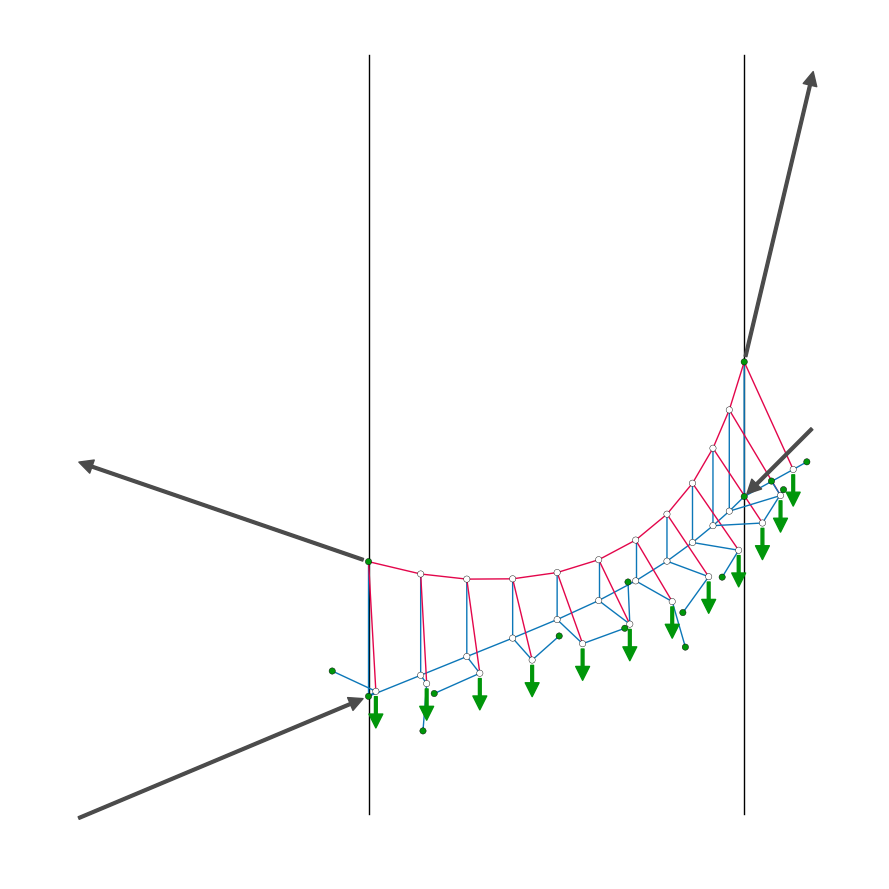

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 42, # Constraints 16
Optimization ended correctly!


 10%|█         | 1/10 [00:18<02:44, 18.24s/it]

Optimization total runtime: 17.808136 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000144
Norm of the gradient of the objective function: 0.006363
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 42, # Constraints 16
Optimization ended correctly!


 10%|█         | 1/10 [00:23<03:30, 23.39s/it]

Optimization total runtime: 22.960975 seconds
Number of evaluations incurred: 62
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001148
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 42, # Constraints 16
Optimization ended correctly!


 10%|█         | 1/10 [00:23<03:29, 23.30s/it]

Optimization total runtime: 22.872996 seconds
Number of evaluations incurred: 62
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001119
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 42, # Constraints 16
Optimization ended correctly!


 10%|█         | 1/10 [00:23<03:29, 23.33s/it]

Optimization total runtime: 22.906311 seconds
Number of evaluations incurred: 64
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001141
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 14 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 48, # Constraints 18
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:09<01:23,  9.27s/it]

Optimization ended correctly!
Optimization total runtime: 9.159634 seconds
Number of evaluations incurred: 69
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.001086
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [01:32<00:00,  9.24s/it]

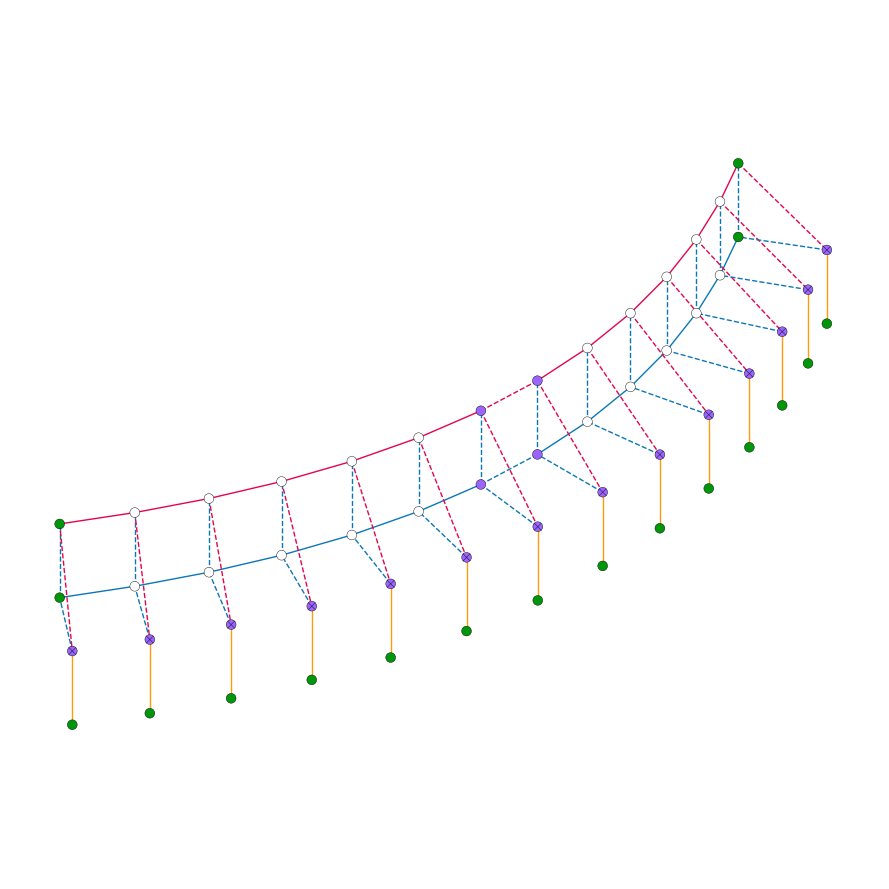

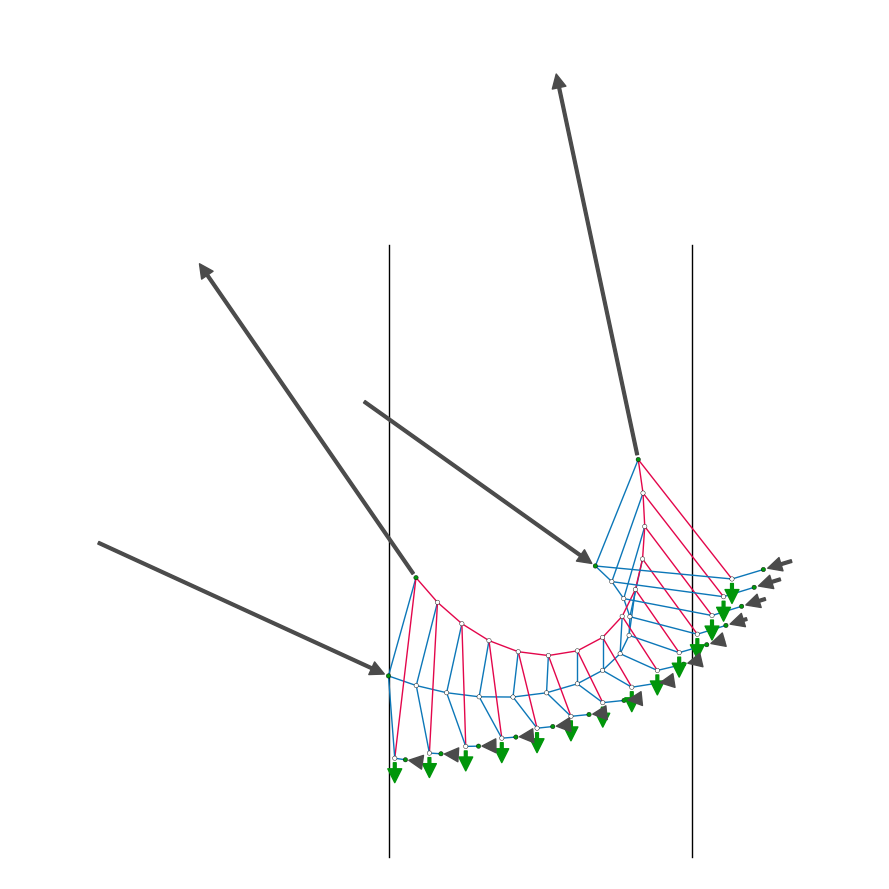

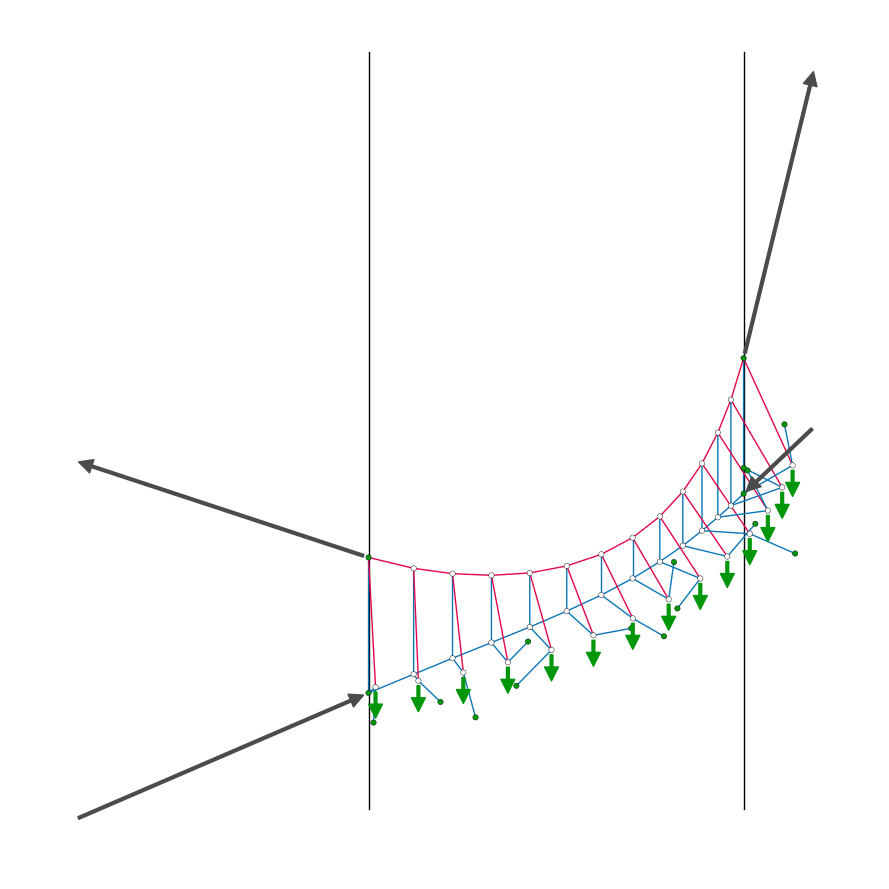

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 48, # Constraints 18
Optimization ended correctly!


 10%|█         | 1/10 [00:23<03:35, 23.89s/it]

Optimization total runtime: 23.352564 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000147
Norm of the gradient of the objective function: 0.004857
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 48, # Constraints 18
Optimization ended correctly!


 10%|█         | 1/10 [00:32<04:56, 32.93s/it]

Optimization total runtime: 32.372687 seconds
Number of evaluations incurred: 69
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.001077
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 48, # Constraints 18
Optimization ended correctly!


 10%|█         | 1/10 [00:31<04:41, 31.33s/it]

Optimization total runtime: 30.761104 seconds
Number of evaluations incurred: 63
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001311
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 48, # Constraints 18
Optimization ended correctly!


 10%|█         | 1/10 [00:32<04:51, 32.39s/it]

Optimization total runtime: 31.837431 seconds
Number of evaluations incurred: 66
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001336
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 16 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 54, # Constraints 20
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:10<01:33, 10.42s/it]

Optimization ended correctly!
Optimization total runtime: 10.295851 seconds
Number of evaluations incurred: 64
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000985
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [01:43<00:00, 10.33s/it]

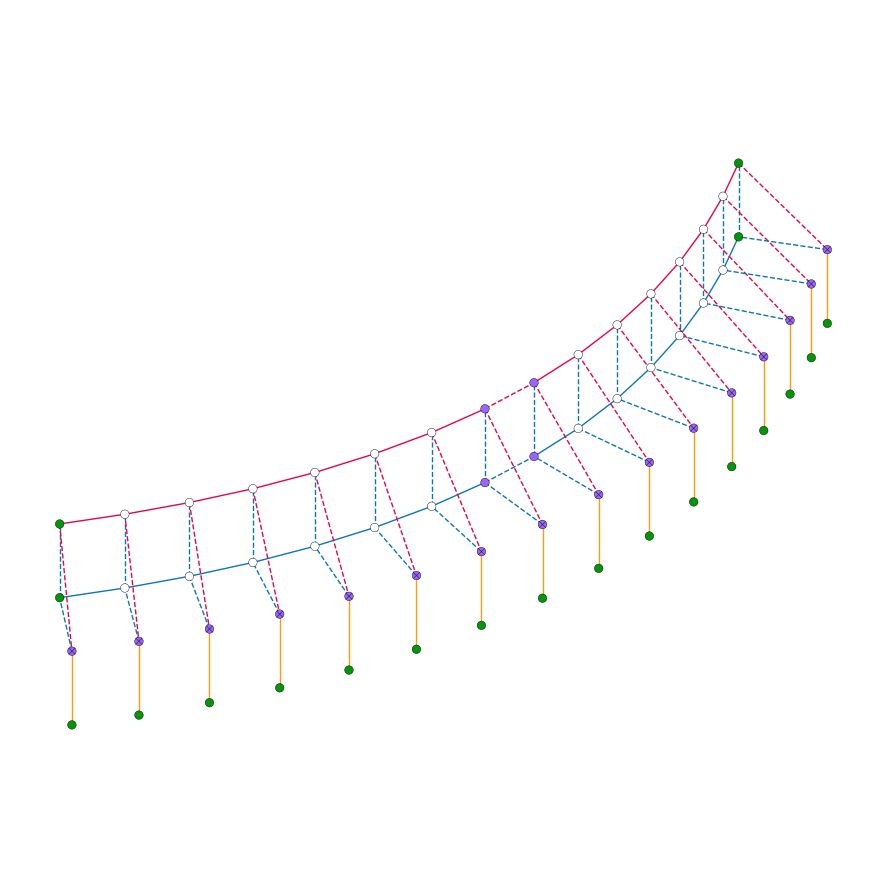

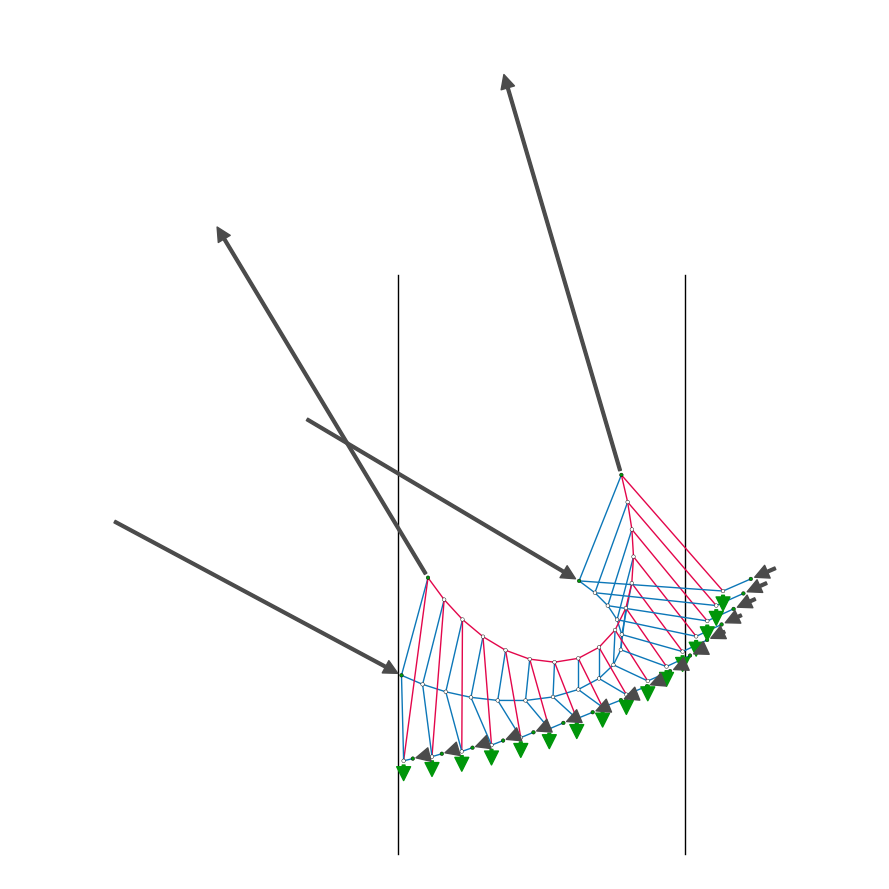

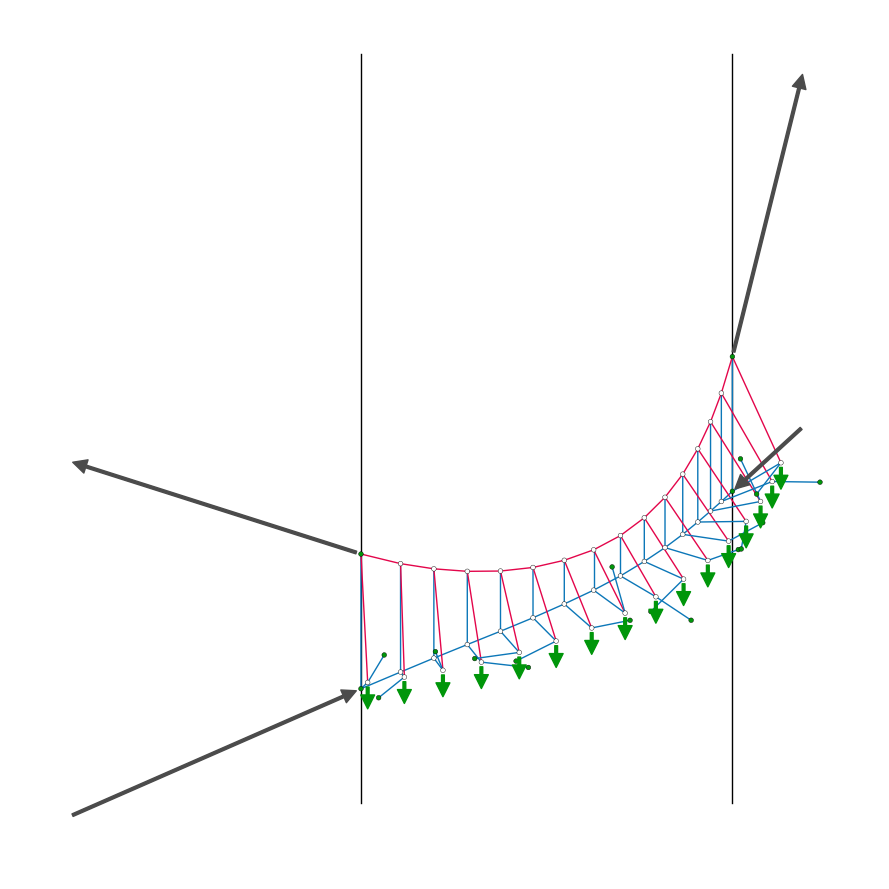

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 54, # Constraints 20
Optimization ended correctly!


 10%|█         | 1/10 [00:30<04:32, 30.25s/it]

Optimization total runtime: 29.560862 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000145
Norm of the gradient of the objective function: 0.003748
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 54, # Constraints 20
Optimization ended correctly!


 10%|█         | 1/10 [00:38<05:46, 38.54s/it]

Optimization total runtime: 37.873258 seconds
Number of evaluations incurred: 61
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001462
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 54, # Constraints 20
Optimization ended correctly!


 10%|█         | 1/10 [00:41<06:13, 41.54s/it]

Optimization total runtime: 40.812079 seconds
Number of evaluations incurred: 65
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.000676
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 54, # Constraints 20
Optimization ended correctly!


 10%|█         | 1/10 [00:41<06:11, 41.32s/it]

Optimization total runtime: 40.625734 seconds
Number of evaluations incurred: 65
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001003
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 18 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 60, # Constraints 22
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:12<01:52, 12.51s/it]

Optimization ended correctly!
Optimization total runtime: 12.372834 seconds
Number of evaluations incurred: 69
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000407
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [02:03<00:00, 12.32s/it]

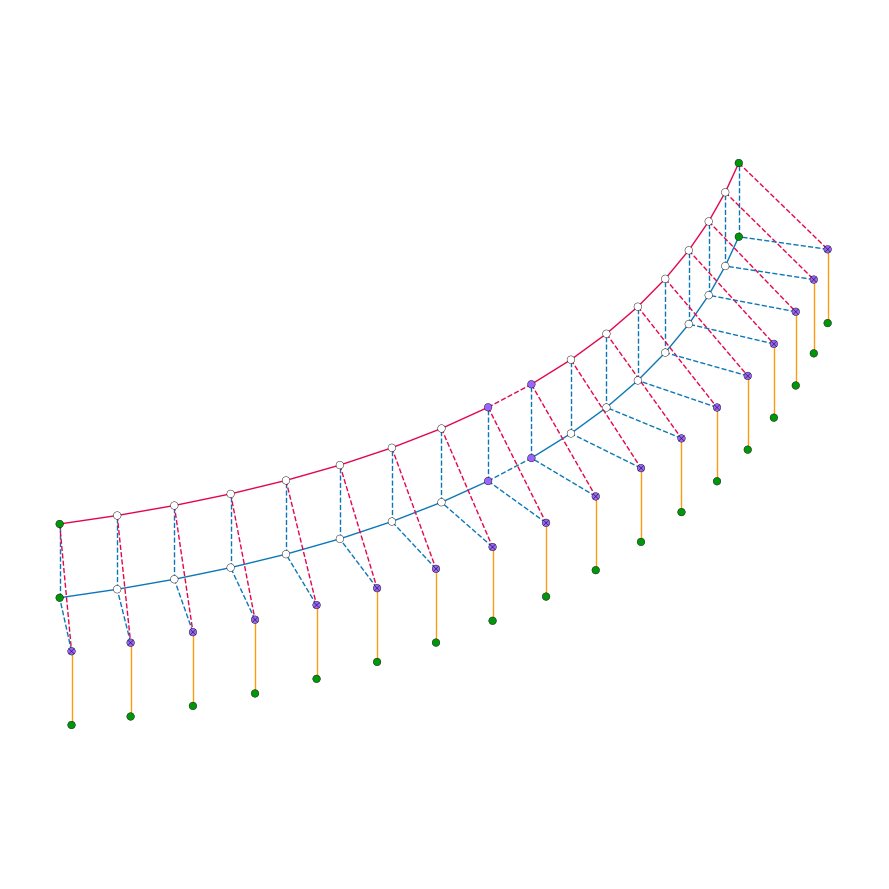

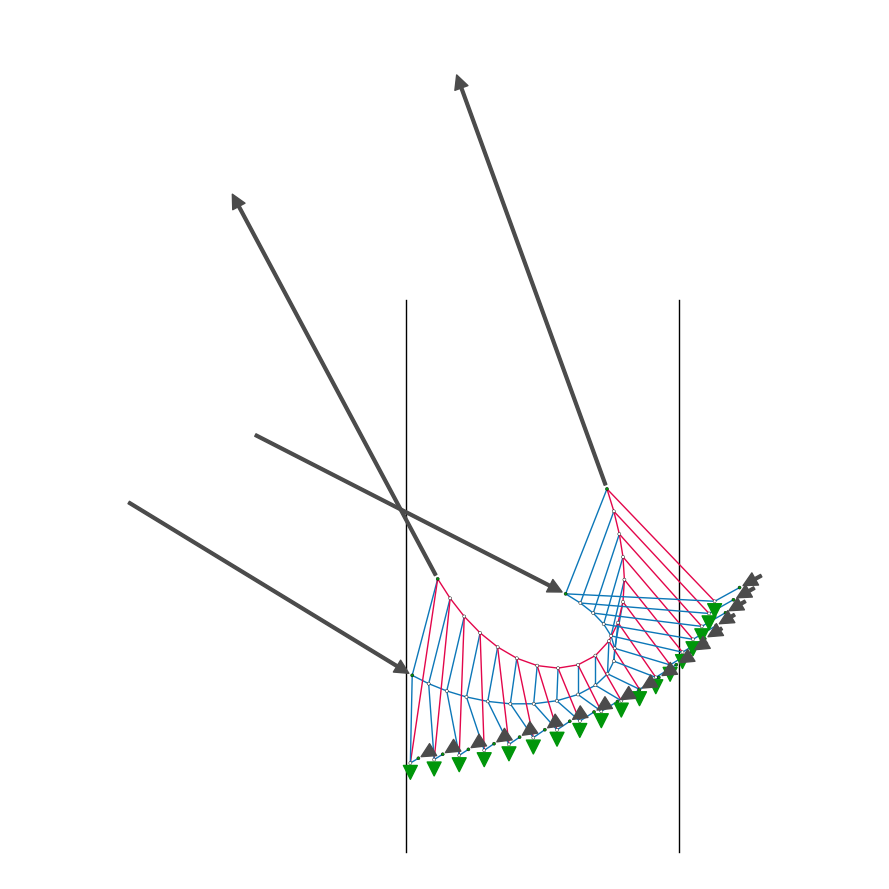

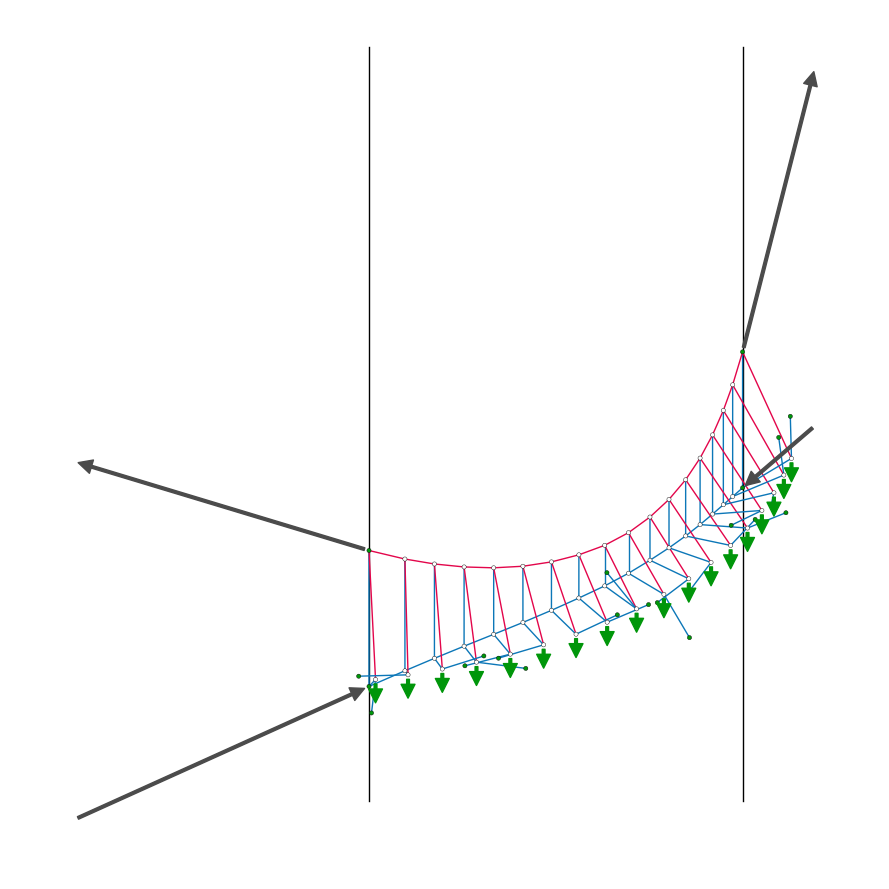

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 60, # Constraints 22
Optimization ended correctly!


 10%|█         | 1/10 [00:45<06:47, 45.26s/it]

Optimization total runtime: 44.381807 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000159
Norm of the gradient of the objective function: 0.001547
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 60, # Constraints 22
Optimization ended correctly!


 10%|█         | 1/10 [00:53<07:57, 53.05s/it]

Optimization total runtime: 52.214747 seconds
Number of evaluations incurred: 69
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000413
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 60, # Constraints 22
Optimization ended correctly!


 10%|█         | 1/10 [00:52<07:48, 52.09s/it]

Optimization total runtime: 51.256078 seconds
Number of evaluations incurred: 67
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000862
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 60, # Constraints 22
Optimization ended correctly!


 10%|█         | 1/10 [00:52<07:48, 52.03s/it]

Optimization total runtime: 51.191775 seconds
Number of evaluations incurred: 65
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000277
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 20 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 66, # Constraints 24
Computing gradients using automatic differentiation!
Optimization ended correctly!


 10%|█         | 1/10 [00:17<02:37, 17.47s/it]

Optimization total runtime: 17.198121 seconds
Number of evaluations incurred: 85
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001205
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [02:53<00:00, 17.37s/it]

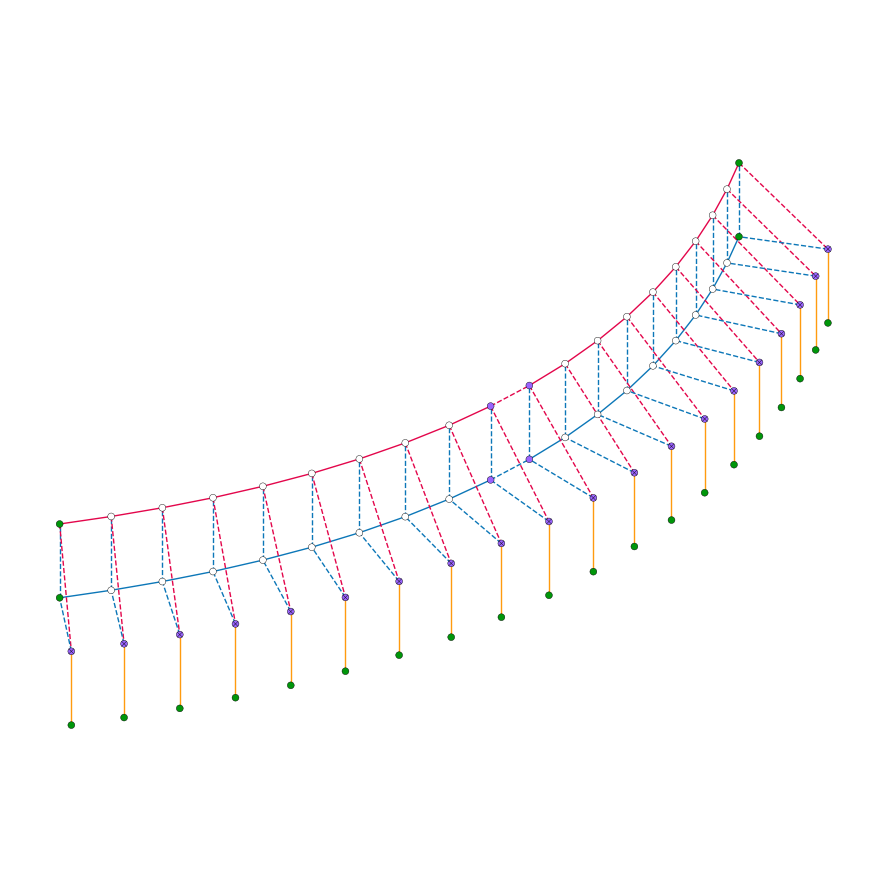

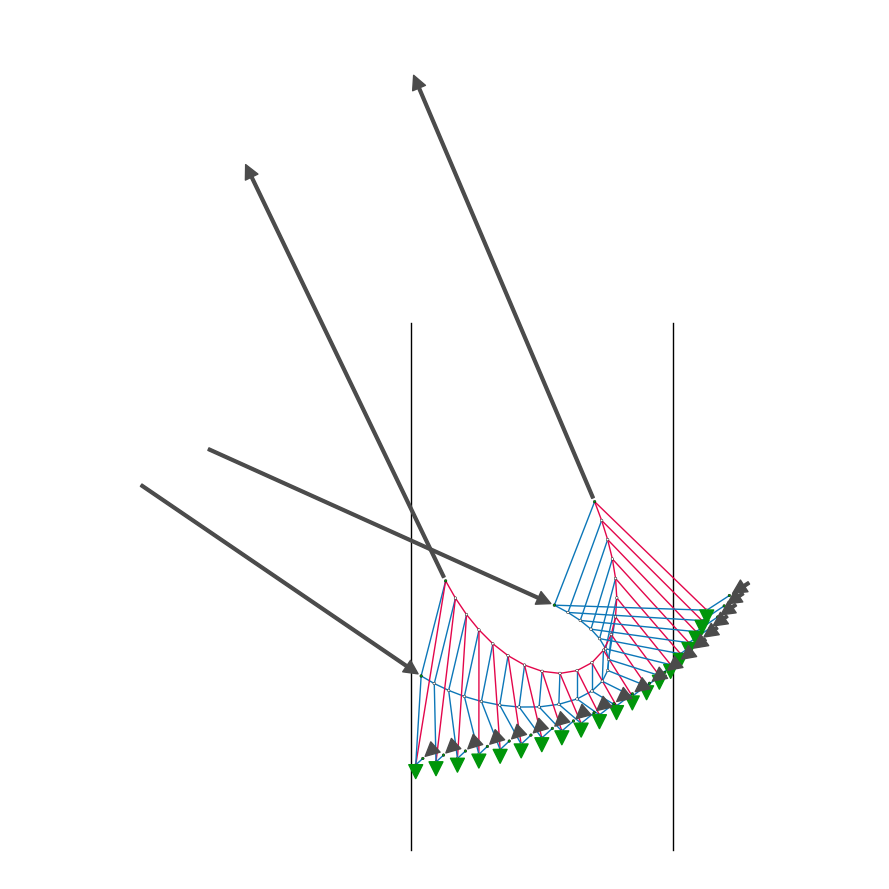

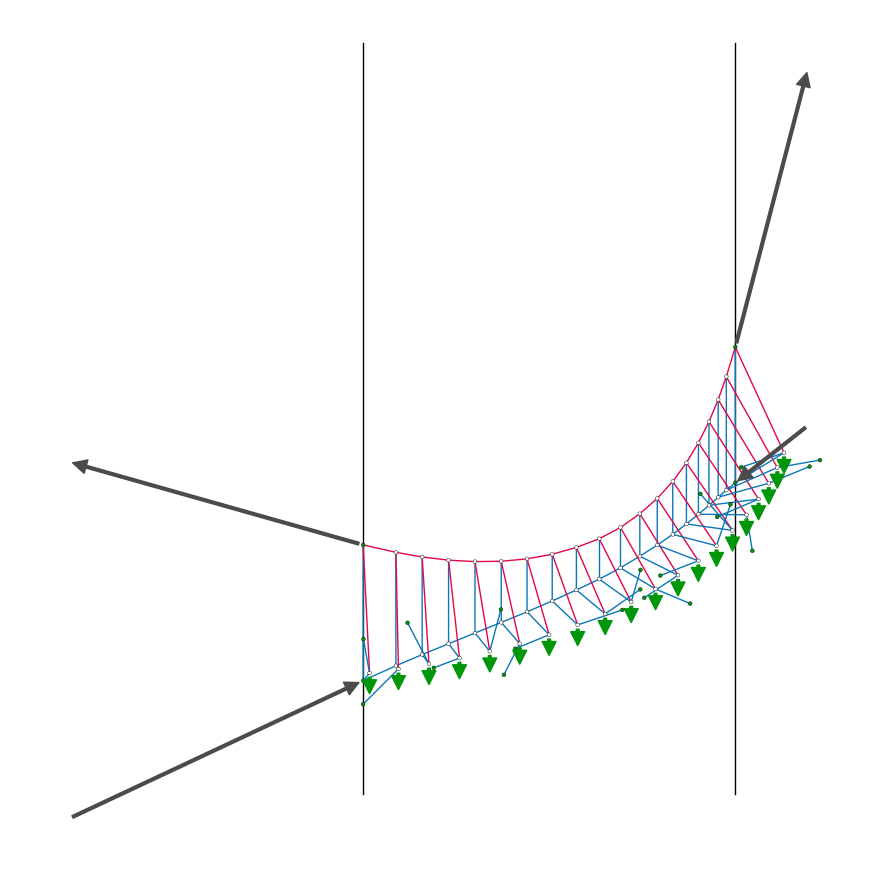

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 66, # Constraints 24
Optimization ended correctly!


 10%|█         | 1/10 [00:50<07:38, 50.91s/it]

Optimization total runtime: 49.883987 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.000259
Norm of the gradient of the objective function: 0.003535
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 66, # Constraints 24
Optimization ended correctly!


 10%|█         | 1/10 [01:20<12:07, 80.86s/it]

Optimization total runtime: 79.79858 seconds
Number of evaluations incurred: 84
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.001096
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 66, # Constraints 24
Optimization ended correctly!


 10%|█         | 1/10 [01:21<12:11, 81.26s/it]

Optimization total runtime: 80.223836 seconds
Number of evaluations incurred: 85
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000632
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 66, # Constraints 24
Optimization ended correctly!


 10%|█         | 1/10 [01:31<13:39, 91.10s/it]

Optimization total runtime: 90.032354 seconds
Number of evaluations incurred: 96
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000362
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving for bridge with 22 hangers***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 72, # Constraints 26
Computing gradients using automatic differentiation!
Optimization ended correctly!


 10%|█         | 1/10 [00:20<03:04, 20.55s/it]

Optimization total runtime: 20.257343 seconds
Number of evaluations incurred: 90
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000868
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [03:24<00:00, 20.49s/it]

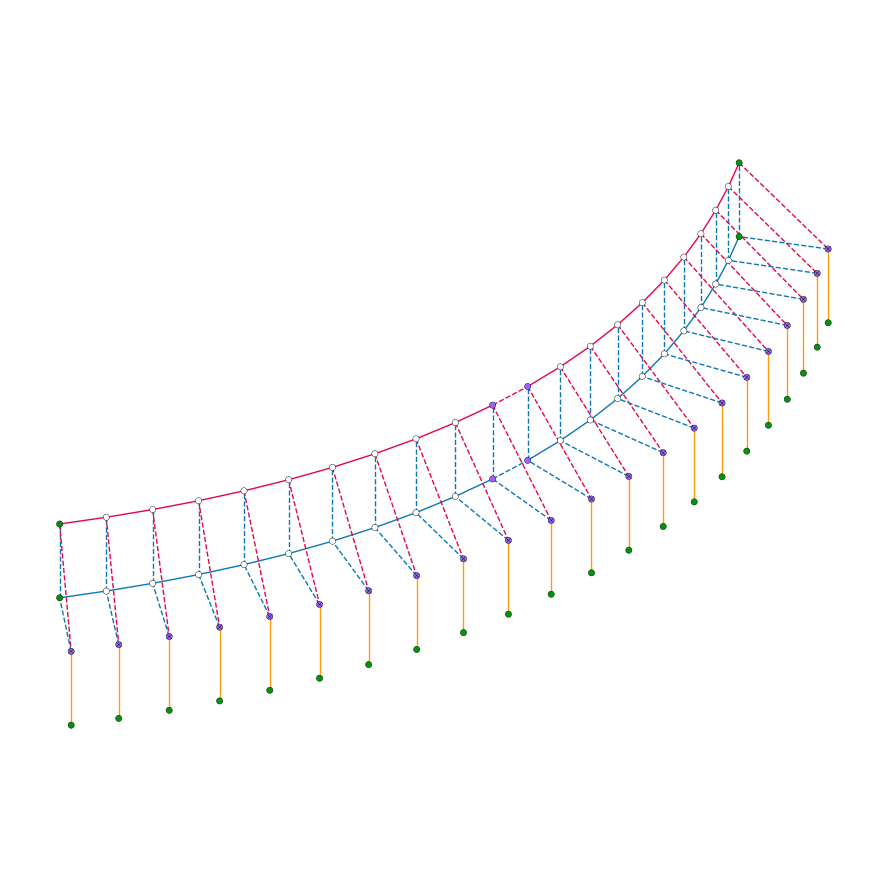

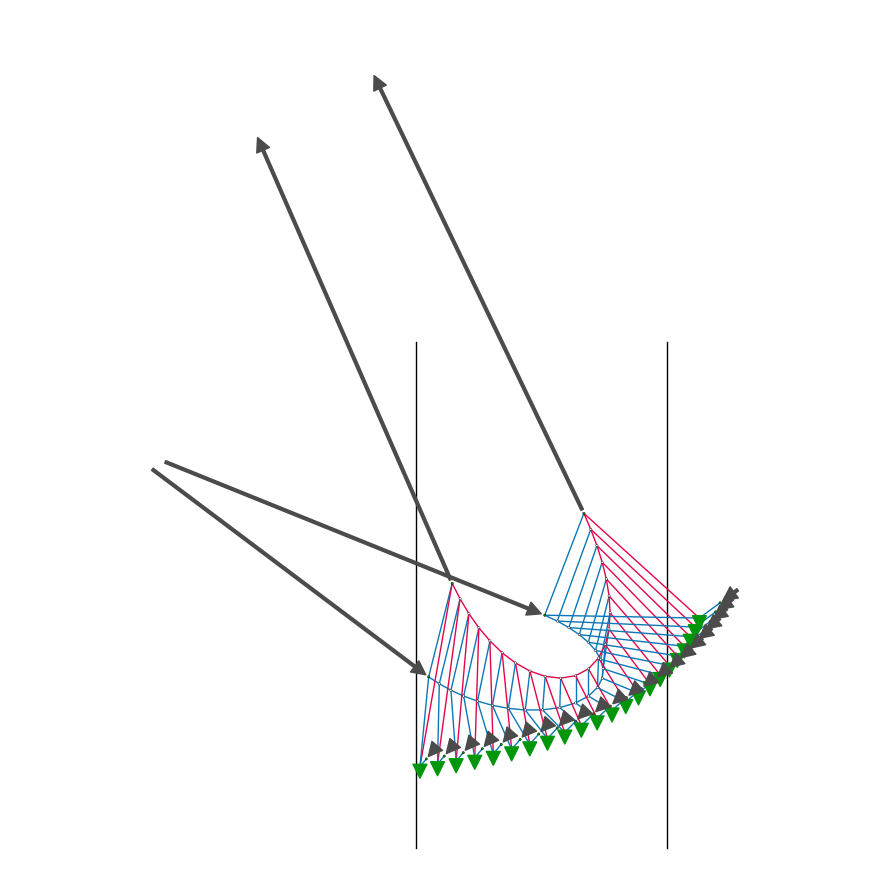

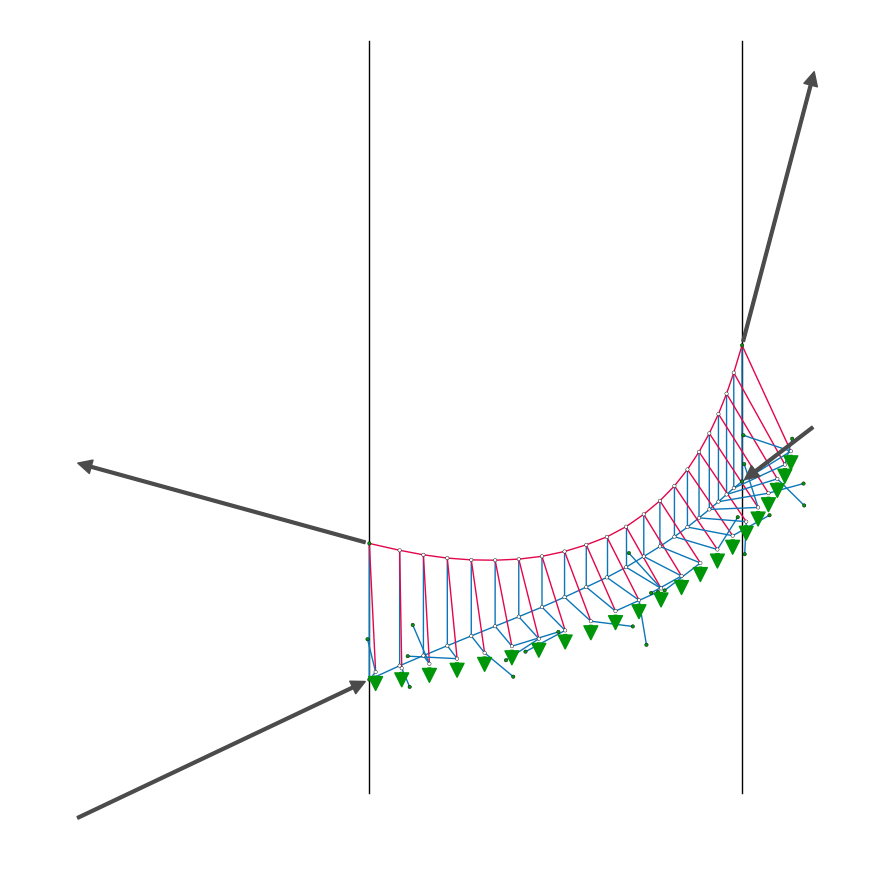

  0%|          | 0/10 [00:00<?, ?it/s]

Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 72, # Constraints 26
Optimization ended correctly!


 10%|█         | 1/10 [01:07<10:03, 67.07s/it]

Optimization total runtime: 65.831996 seconds
Number of evaluations incurred: 100
Final value of the objective function: 0.0006
Norm of the gradient of the objective function: 0.002394
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 72, # Constraints 26
Optimization ended correctly!


 10%|█         | 1/10 [01:42<15:24, 102.70s/it]

Optimization total runtime: 101.462889 seconds
Number of evaluations incurred: 90
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000959
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 72, # Constraints 26
Optimization ended correctly!


 10%|█         | 1/10 [01:43<15:33, 103.75s/it]

Optimization total runtime: 102.50497 seconds
Number of evaluations incurred: 92
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000539
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 72, # Constraints 26
Optimization ended correctly!


 10%|█         | 1/10 [01:49<16:24, 109.40s/it]

Optimization total runtime: 108.158393 seconds
Number of evaluations incurred: 94
Final value of the objective function: 1e-06
Norm of the gradient of the objective function: 0.000501
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [18:15<00:00, 109.57s/it]


Done!


In [86]:
logger = Logger()

guide_curve = Polyline.from_json(curve_path)
guide_points = guide_curve.points

target_lines = []
for pt in (guide_points[0], guide_points[-1]):
    x, y, z = pt
    line = Line((x, y, -target_line_height/2.), (x, y, target_line_height/2.))
    target_lines.append(line)

for num_hangers in nums_hangers:
    
    # See bridge's number of hangers
    print(f"***Solving for bridge with {num_hangers} hangers***\n")
    
    # Create chords' geometry
    chord_bottom = Polyline(points=guide_curve.divide(num_hangers - 1))
    chord_top = chord_bottom.transformed(Translation.from_vector([0., 0., height]))
    chord_deck = Polyline(points=offset_polyline(chord_bottom.points, distance=-width))
    
    # Compute node load
    load = load_line * guide_curve.length / num_hangers
    node_load = [0., 0., load]
    
    # Create topology diagram
    topology = bridge(chords=(chord_bottom, chord_top, chord_deck), 
                      num_hangers=num_hangers,
                      height=height,
                      width=width,
                      edge_forces=forces,
                      node_load=node_load)
    
    # Form-finding, only for visualization purposes
    form = static_equilibrium(topology)

    # Constrained form-finding
    # Instantiate an optimizer
    opt = Optimizer()

    # Add constraint: force in axiliary trail edges should be zero
    for edge in topology.auxiliary_trail_edges():
        constraint = TrailEdgeForceConstraint(edge, force=0.)
        opt.add_constraint(constraint)

    # Add constraint: pull support points to target lines
    for chord in (chord_bottom, chord_top):
        points = (chord.points[0], chord.points[-1])
        for pt, line in zip(points, target_lines):
            key = topology.node_key(pt)
            constraint = LineConstraint(key, line)
            opt.add_constraint(constraint)

    # Add optimization parameters
    # The forces in all the deviation edges are the degrees of freedom
    # in the optimization problem
    for edge in topology.deviation_edges():
        parameter = DeviationEdgeParameter(edge, bound_force, bound_force)
        opt.add_parameter(parameter)

    # The length of the trail edges connected to a support that are not an auxiliary trail 
    for edge in topology.trail_edges():
        if topology.is_edge_supported(edge) and not topology.is_auxiliary_trail_edge(edge):
            parameter = TrailEdgeParameter(edge, bound_length, bound_length)
            opt.add_parameter(parameter)

    # Log data
    logger.log_numhangers(num_hangers)
    logger.log_topology(topology)
    logger.log_optimizer(opt)
    
    # Solve constrained form-finding problem
    for gradient_mode, step_size_exps in gradient_strategy.items():
        
        for step_size_exp in step_size_exps:
            step_size = None
            if step_size_exp is not None:
                step_size = 1 * (10 ** step_size_exp)
                
            print(f"Gradient mode: {gradient_mode}\tStep size:{step_size}")
            print(f"Running {num_experiments} experiments...")
            
            for i in tqdm(range(num_experiments)):

                verbose = (i == 0)
                    
                form_opt = opt.solve(topology.copy(),
                                     algorithm=opt_algorithm,
                                     grad=gradient_mode,
                                     iters=iters,
                                     eps=eps,
                                     step_size=step_size,
                                     verbose=verbose)
                
                result = OptimizationResult(evals=opt.evals,
                                            time=opt.time_opt,
                                            penalty=opt.penalty,
                                            grad_norm=opt.gradient_norm,
                                            gradient_mode=gradient_mode,
                                            step_size_exp=step_size_exp)
                
                logger.log_result(result)
            print()
        
        # Plot topology, form and constrained form diagrams
        if gradient_mode == "AD":    
            plot_diagrams(topology, form, form_opt, target_lines, frame_from, frame_to, figsize=figsize)

    logger.flush_results()
        
print("Done!")

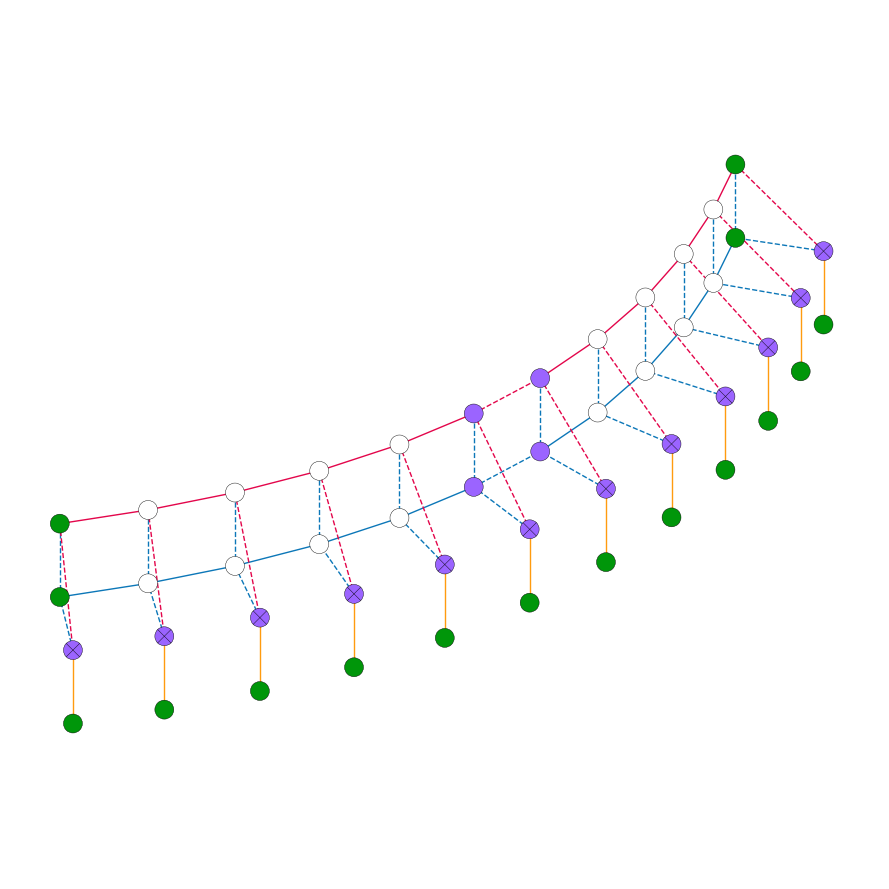

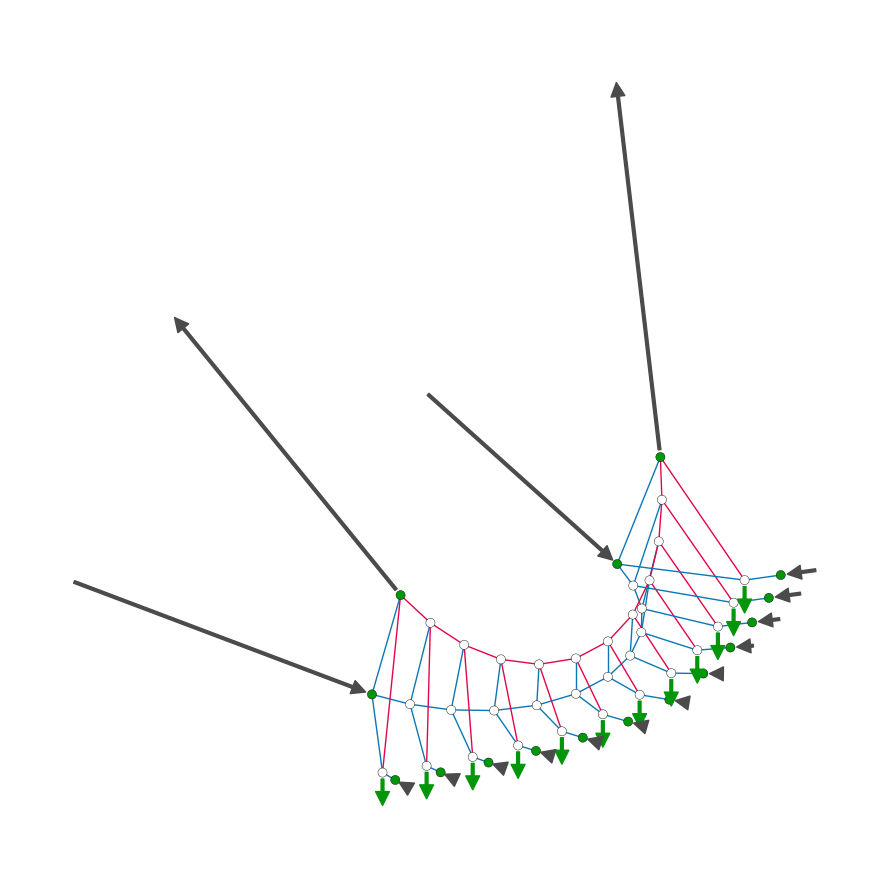

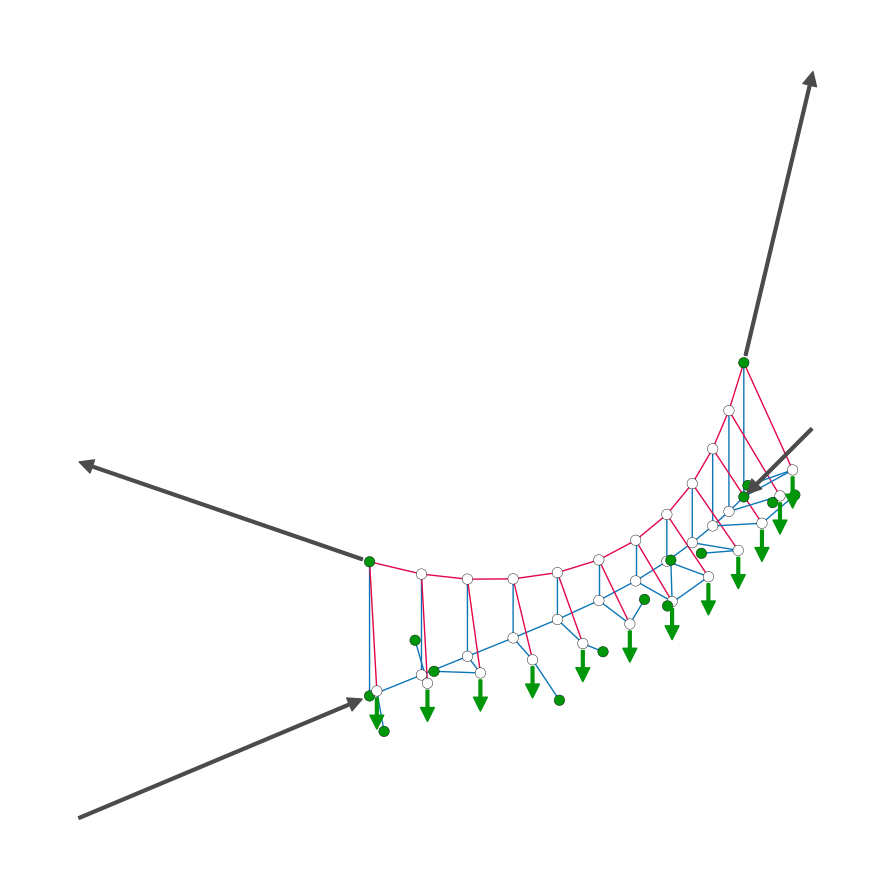

In [53]:
if plot:
    

In [87]:
for key, value in logger.data.items():
    if key != "results":
        print(f"{key}: {value}")
        continue
    for v in value:
        print(v)

num_hangers: [4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
num_nodes: [16, 24, 32, 40, 48, 56, 64, 72, 80, 88]
num_edges: [22, 34, 46, 58, 70, 82, 94, 106, 118, 130]
num_parameters: [18, 24, 30, 36, 42, 48, 54, 60, 66, 72]
num_constraints: [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
{'time': defaultdict(<class 'dict'>, {'AD': {None: [0.5870342254638672, 0.5774011611938477, 0.4644632339477539, 0.4324352741241455, 0.5707330703735352, 0.5594620704650879, 0.5434792041778564, 0.5532751083374023, 0.5540988445281982, 0.5536482334136963]}, 'FD': {-3: [2.0654971599578857, 2.0502841472625732, 2.0085201263427734, 2.053276777267456, 2.020813226699829, 1.9833288192749023, 1.9891409873962402, 1.9899382591247559, 2.013484001159668, 2.079166889190674], -6: [1.1558427810668945, 1.1904959678649902, 1.1373250484466553, 1.191037893295288, 1.2114520072937012, 1.149690866470337, 1.1657867431640625, 1.1162569522857666, 1.155588150024414, 1.1506738662719727], -9: [1.3087060451507568, 1.3433878421783447, 1.314367294311523

In [88]:
with open("bridge.pkl", "wb") as file:
    pickle.dump(logger.data, file, pickle.HIGHEST_PROTOCOL)

In [339]:
def pretty_matplotlib():
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=20)
    plt.rc('axes', linewidth=1.5, labelsize=20)
    plt.rc('xtick', labelsize=20, direction="in")
    plt.rc('ytick', labelsize=20, direction="in")
    plt.rc('legend', fontsize=20)

    # tick settings
    plt.rc('xtick.major', size=10, pad=4)
    plt.rc('xtick.minor', size=5, pad=4)
    plt.rc('ytick.major', size=10)
    plt.rc('ytick.minor', size=5)

    
def create_figure(figsize, dpi):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    return fig


def plot_xy(x, y, label, lw=2.0, alpha=1.0, marker="o", ms=None, color=None):
    return plt.plot(x, y, label=label, lw=lw, alpha=alpha, marker=marker, color=color, ms=ms)
    
    
def save_figure(filename, extension="pdf", box_inches="tight", pad_inches=0.05, sleeptime=1.0):
    path = f"{filename}.{extension}"
    plt.savefig(path, bbox_inches='tight', pad_inches=pad_inches)
    print(f"Saved image to {path}")
    sleep(sleeptime)
    
    
def show_figure():
    plt.show()

    
def decorate_figure(xlabel, ylabel, xticks, yticks, ylabelpad=None, xscale="linear", yscale="linear", legend=True, legend_loc="best", legend_fontsize="small", grid_kwargs={}, tight=True):
    plt.xscale(xscale)
    plt.yscale(yscale)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel, labelpad=ylabelpad)
    
    plt.xticks(xticks, labels=xticks)
    plt.yticks(yticks, labels=yticks)
    
    plt.minorticks_off()
    
    plt.grid(**grid_kwargs)
    
    if legend:
        plt.legend(fontsize=legend_fontsize, loc=legend_loc)
        
    if tight:
        plt.tight_layout()

In [361]:
data = logger.data

save = True
show = True

filename = "bridge_opt"
figsize = (7, 5)  # 8, 5
dpi = 300
margins = (0.1, 0.15)

aggregator_func = mean
# skippable_step_size_exps = [-12]

x = data["num_parameters"]
xscale = "linear"
xlabel = r"\# Optimization parameters"
xticks = [int(_x) for _x in x]

markers = {"AD": {None: "o"}, "FD": {-3: "s", -6: "X", -9: "D", -12: "v"}}
grid = {"ls": "--", "lw": 0.5, "which": "major", "axis": "both"}
colors = {"AD": {None: "tab:blue"}, "FD": {-3: "tab:orange", -6: "tab:green", -9: "tab:red", -12: "tab:purple"}}
alpha = 0.6
lineweights = {"AD": {None: 2.5}, "FD": {-6: 2.5, -9: 2, -12: 1.5}}
lw_default = 2.
markersizes = {"FD": {-6: 7, -9: 5, -12: 6}}
ms_default = 7 

text = {"AD": {None: {"plot": True, "indices": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], "va": "top", "ha": "left","tag": "percentage"}},
        "FD": {-3: {"plot": False, "indices": [5, 6], "tag": "percentage"},
               -6: {"plot": True, "indices": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], "va": "bottom", "ha": "right", "tag": "percentage"},
               -9: {"plot": False, "indices": [3, 6, 8, 9], "va": "botttom", "ha": "left", "tag": "percentage"},
              -12: {"plot": False, "indices": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], "tag": "percentage"}},
       }

text_conv = {
              "FD": {-3: {"plot": True, "indices": [0] + list(range(1, 10, 2)), "va": "bottom", "ha": "center", "tag": "percentage"}}}

text_evals = {
              "FD": {-3: {"plot": False, "indices": [5, 6], "tag": "int"}}}

y_metrics = {"time": {"ylabel": "Time (seconds)",
                      "yscale": "log",
                      "yticks": None, #[0, 25, 50, 75, 100, 125],
                      "legend_loc": "lower right",
                      "text": text,
                      "ylabelpad": 12,
                      "skippable": [-3]},
             "penalty": {"ylabel": r"$\mathcal{L}(\mathbf{s})/\epsilon$",
                        "yscale": "log",
                        "yticks": None,
                        "legend_loc": (0.5, 0.37),
                        "text": text_conv,
                        "skippable": []},
             "evals": {"ylabel": r"\# Iterations",
                       "yscale": "linear",
                       "yticks": None,
                       "legend_loc": "best",
                       "text": text_evals,
                       "skippable": []}
            }

Saved image to bridge_opt_time.pdf


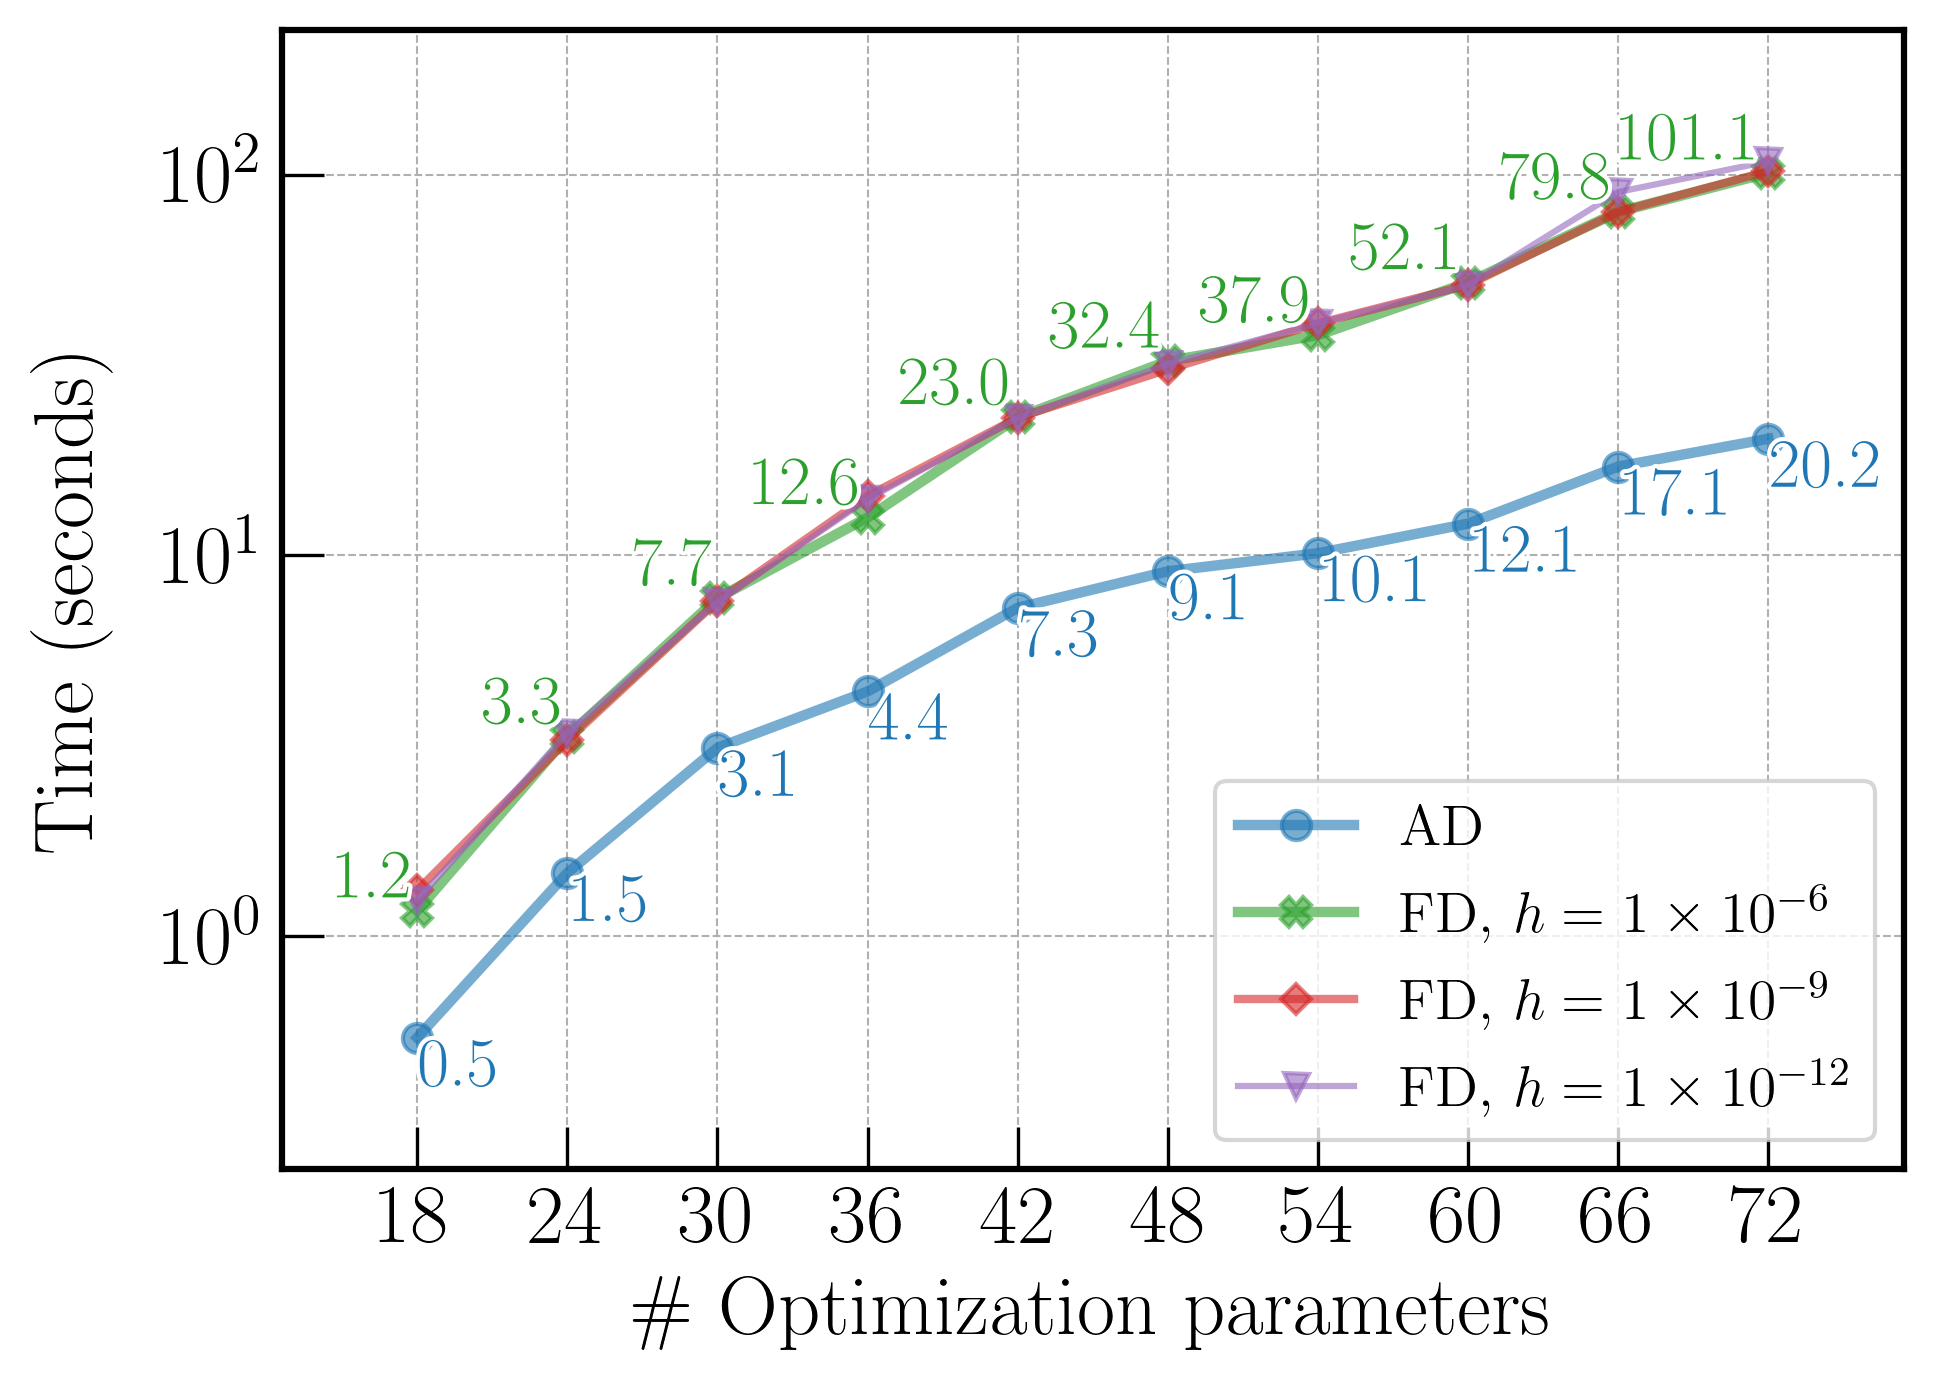

Saved image to bridge_opt_penalty.pdf


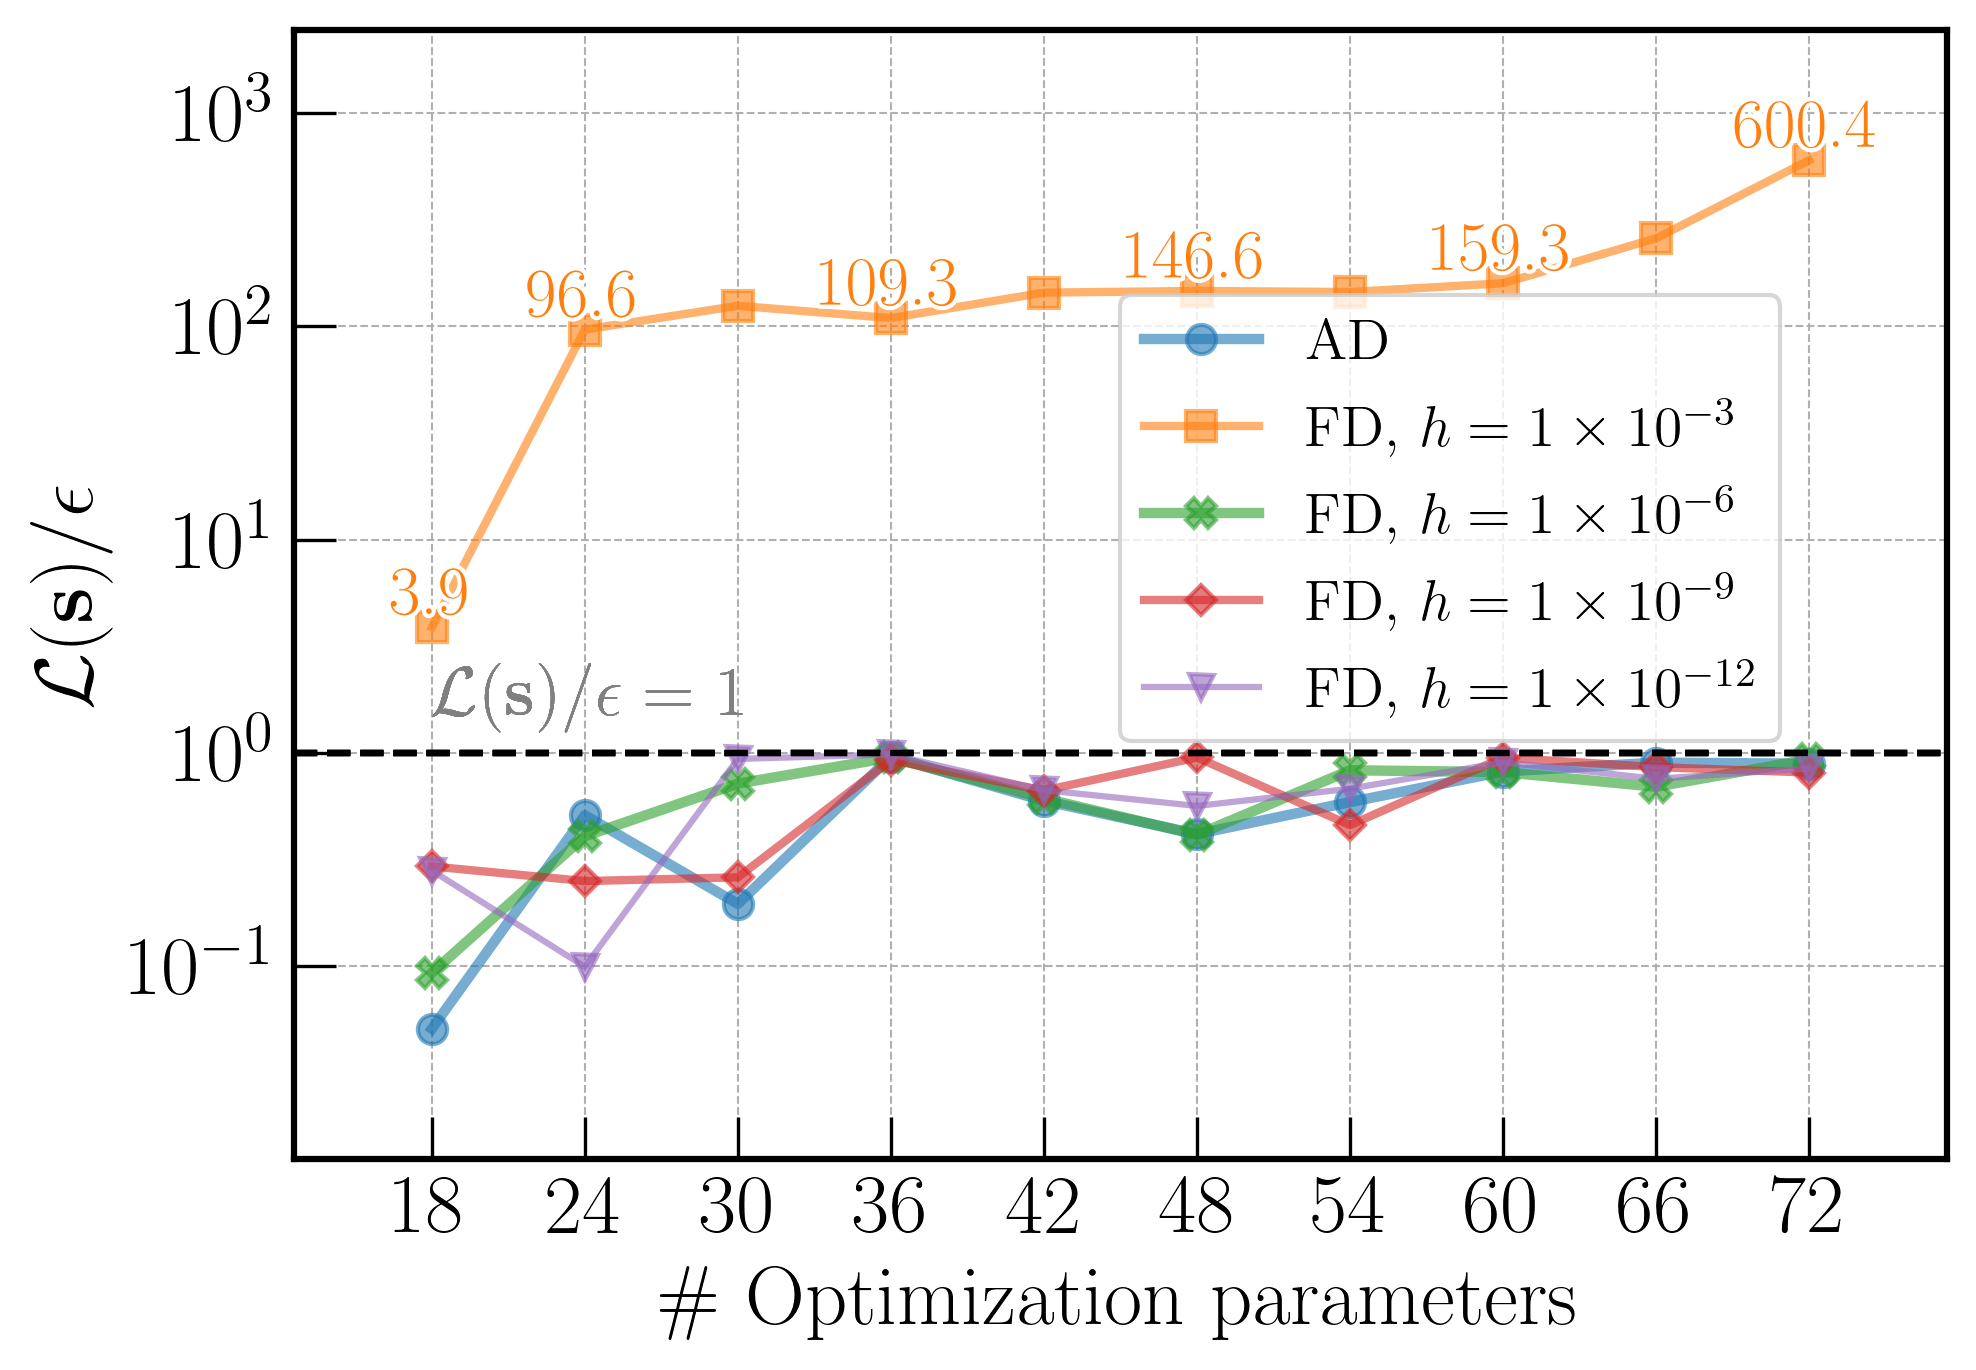

Saved image to bridge_opt_evals.pdf


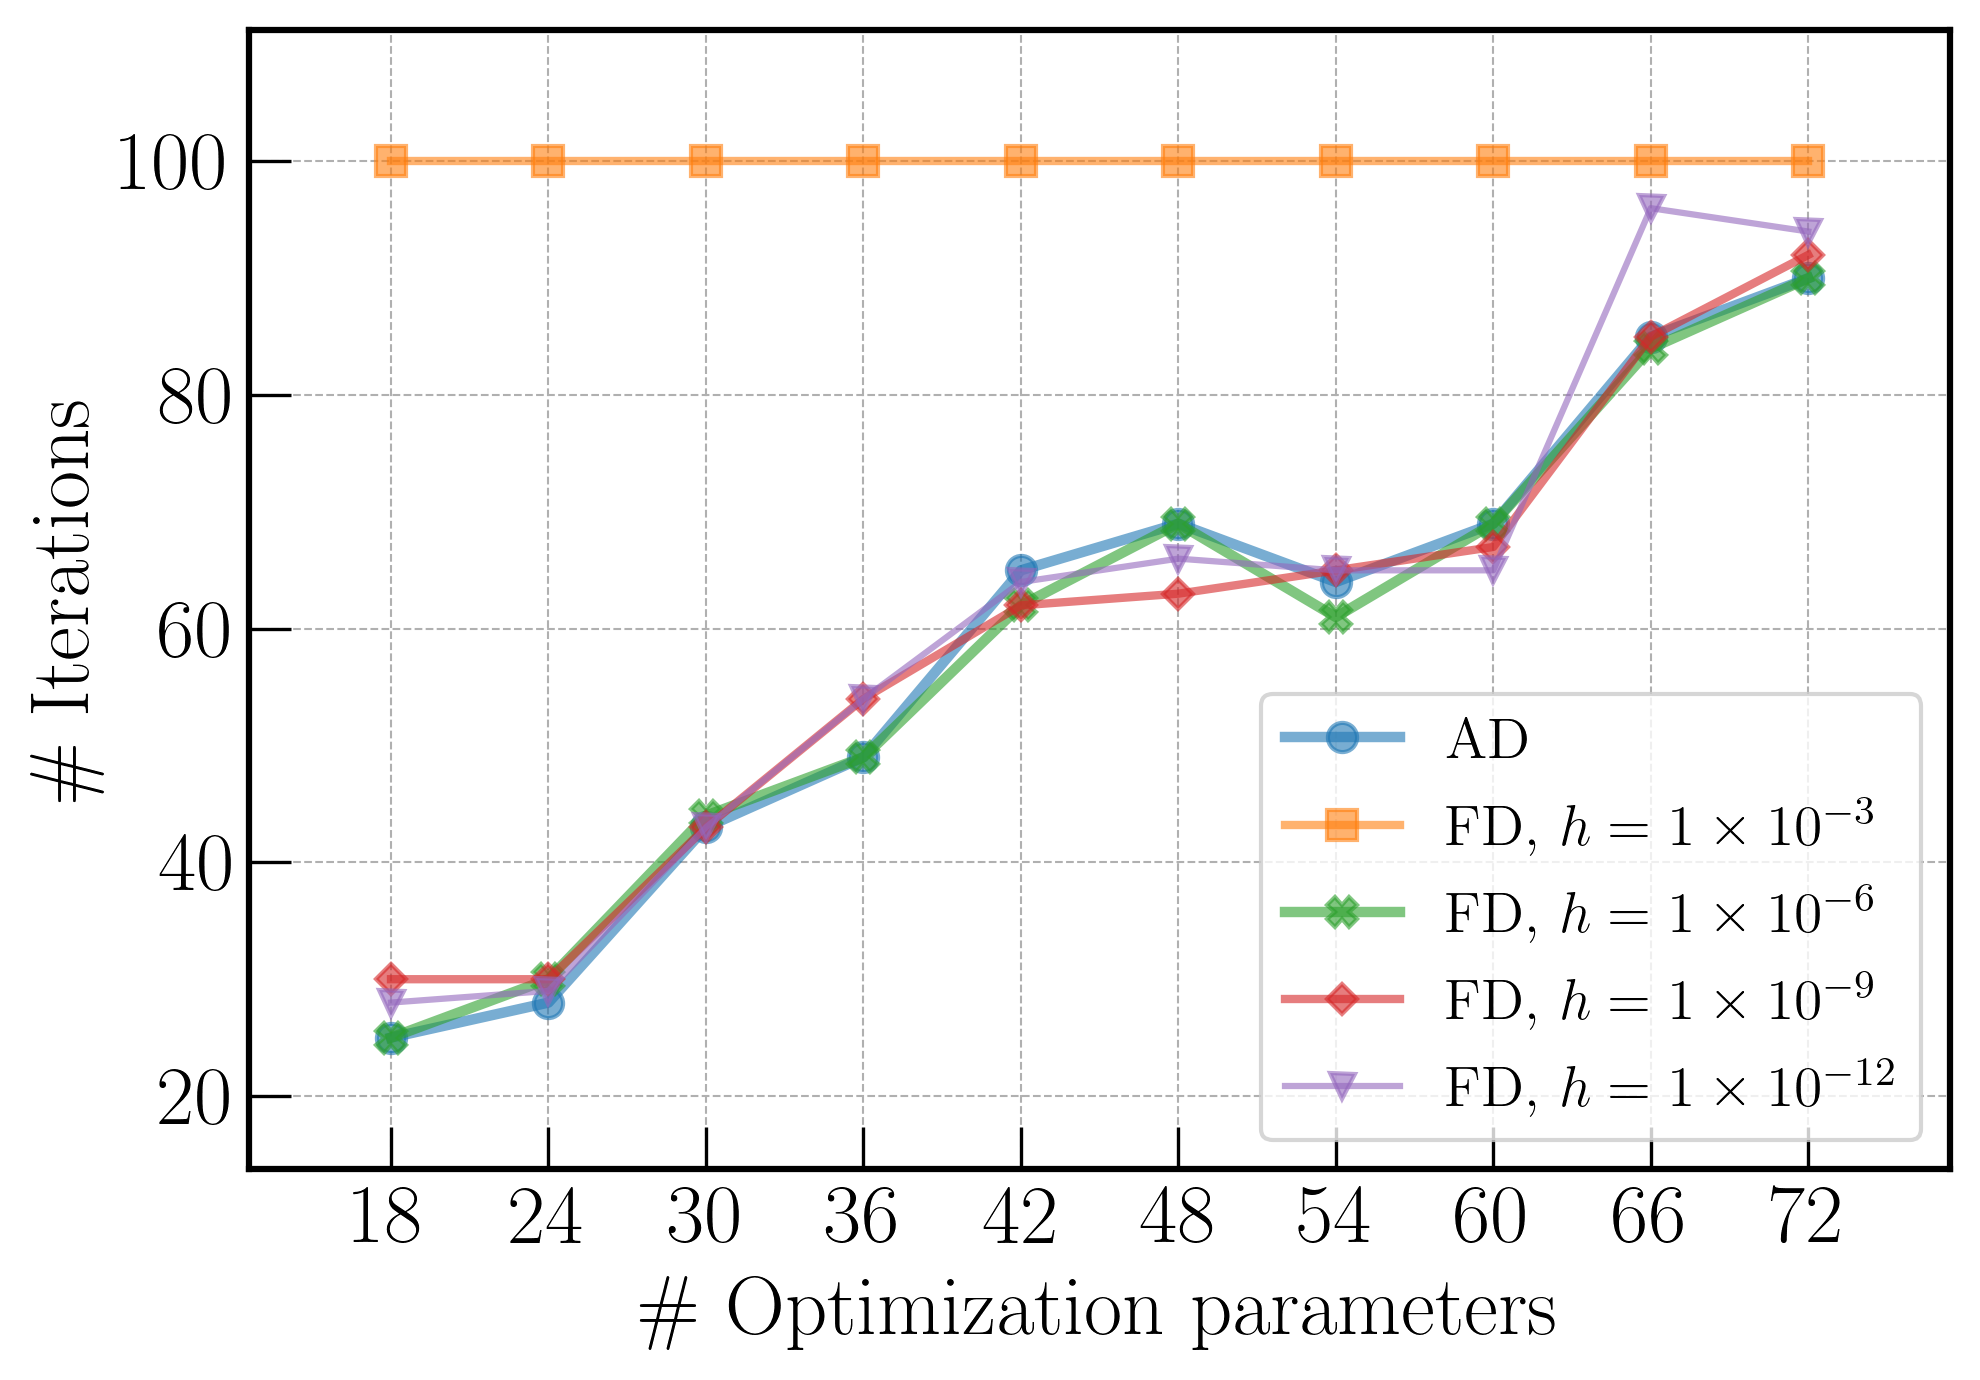

In [364]:
pretty_matplotlib()

for metric, ykwargs in y_metrics.items():
    
    create_figure(figsize, dpi)
    
    for gradient_mode, step_size_exps in gradient_strategy.items():

        for step_size_exp in step_size_exps:

            skippable_step_size_exps = ykwargs["skippable"]
            
            if step_size_exp in skippable_step_size_exps:
                continue

            label = fr"{gradient_mode}, $h=1\times10^{ {step_size_exp} }$"
            if step_size_exp is None:
                label = r"{}".format(gradient_mode)

            y = []
            for result in data["results"]:
                ys = result[metric][gradient_mode][step_size_exp]
                if metric == "penalty":
                    ys = [_y / eps for _y in ys]
                y.append(aggregator_func(ys))

            try:
                lw = lineweights[gradient_mode][step_size_exp]
            except KeyError:
                lw = lw_default     
            try:
                ms = markersizes[gradient_mode][step_size_exp]
            except KeyError:
                ms = ms_default
            color = colors[gradient_mode][step_size_exp]
            
            lines = plot_xy(x, y, label, color=color, lw=lw, alpha=alpha, ms=ms, marker=markers[gradient_mode][step_size_exp])
            
            if metric == "penalty":
                # target line
                plt.axhline(y=1.0, color='black', linestyle='--')
                plt.annotate(r"$\mathcal{L} (\mathbf{s}) / \epsilon=1$", (18, 1.50), fontsize="small", color="gray")
            
            # add text
            text = ykwargs["text"]
            try:
                text_kw = text[gradient_mode][step_size_exp]
            except KeyError:
                continue

            if not text_kw["plot"]:
                continue
            
            tag = text_kw["tag"]
            
            for idx in text_kw["indices"]:
                
                if tag == "percentage":
                    text_tag = f"{y[idx]:.1f}"
                elif tag == "int":
                    text_tag = f"{int(y[idx])}"
                
                plt.text(x[idx],
                         y[idx],
                         text_tag,
                         size="small",
                         c=color,
                         ha=text_kw.get("ha", "right"),
                         va=text_kw.get("va", "bottom"),
                         path_effects=[pe.withStroke(linewidth=2, foreground='w')],
                         zorder=20000)
    
    decorate_figure(xlabel=xlabel,
                    ylabel=ykwargs.get("ylabel"),
                    xticks=xticks,
                    yticks=ykwargs.get("yticks"),
                    xscale=xscale,
                    yscale=ykwargs.get("yscale"),
                    legend_loc=ykwargs.get("legend_loc"),
                    legend_fontsize="x-small",
                    ylabelpad=ykwargs.get("ylabelpad"),
                    grid_kwargs=grid)
    if margins:
        plt.margins(*margins)

    if save:
        save_figure(f"{filename}_{metric}")

    if show:
        show_figure()